In [1]:
import requests
from IPython.core.display import HTML

# PCA for shape generation

**Mandatory assignment 2**
This is the second mandatory assignment, to be submitted on LearnIT as a Jupyter Notebook containing your implementation and notes by the deadline specified on [LearnIT](https://learnit.itu.dk/)
. Details on the submission process can be found [here](https://iml.itu.dk/01-about_the_course/01-AboutTheCourse.html)
.
In this assignment, PCA will be applied to generate face shapes. The objective is to explore the relationship between points in the latent space and their corresponding representations in the data space.

<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">


<article class="message">
    <div class="message-body">
        <strong>Overview of mandatory tasks</strong>
        <ul style="list-style: none;">
            <li>
            <a href="#prep">Task 1: Data inspection</a>
            </li>
            <li>
            <a href="#get_pca">Task 2: Get principal compontents</a>
            </li>
            <li>
            <a href="#gen">Task 3: Base face</a>
            </li>
            <li>
            <a href="#gen_reflect">Task 4: Base face reflections </a>
            </li>
            <li>
            <a href="#c">Task 5: Investigate variations in latent space</a>
            </li>
            <li>
            <a href="#interpolate">Task 6: Interpolation between two faces</a>
            </li>
            <li>
            <a href="#reflect">Task 7: Reflection</a>
            </li>
            <li>
            <a href="#correlation_eigen">Task 8: Eigenvalues and eigenvectors of correlat…</a>
            </li>
            <li>
            <a href="#Dimensionality_red">Task 9: Out of distribution generation</a>
            </li>
        </ul>
    </div>
</article>



</div>


**Important**
Solve the in-class exercise about PCA **before starting on this assignment**. You are of course welcome to ask about both the in-class exercise and the assignment. 

## Data
The dataset used for the assigment consist of 120 landmarks (2D points) of faces (data space). A face consists of 73 (x,y)-coordinate pairs, i.e. 146 featues in total.

---
**Task 1 (easy): Data inspection👩‍💻**
1. Run the cell below to load libraries, the data and to  visualize the first 6 sample face shapes.


---

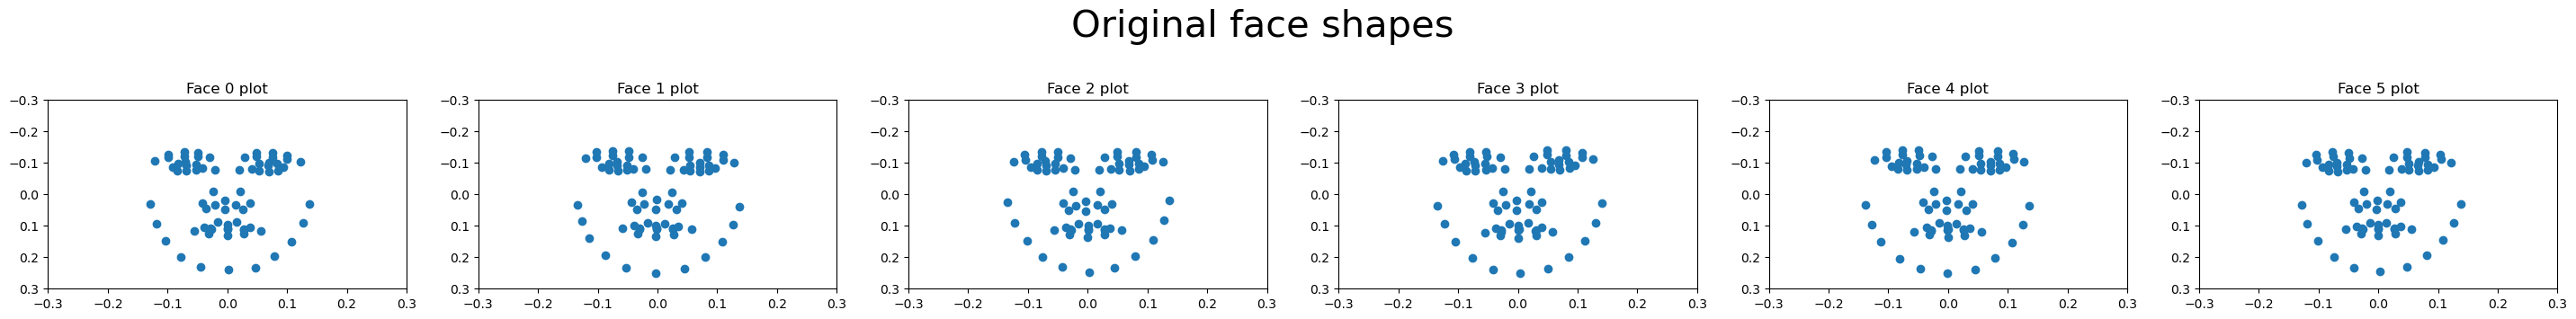

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from pca_utils import *
import os
from glob import glob

path = './db/'
shapes, _ = face_shape_data(path)

plot_many_faces(shapes[:6],"Original face shapes")

## PCA implementation
The following tasks are about using the implementation of PCA from the in-class exercise on the face shape dataset. 

---
**Task 2 (easy): Get principal compontents👩‍💻**
1. Complete the `get_principal_components`
 function so that it returns all principal components `comp`
, eigenvalues `val`
 and mean vector `mu`
, given the dataset `shapes`
.
2. Use the `get_principal_components`
 function to calculate the principal components (`comp`
) for the face dataset.
3. How many components are needed to retain $50\%$, $60\%$, $80\%$, $95\%$ of the total variation?
4. Set $k=5$ components. How much of the total variance is retained?
5. Implement the function `transform_to_latent_space`
  according to the comments in the cell below using  $\mathbf{a} = \mathbf{\Phi_k}^\top(\mathbf{x}-\mathbf{\mu})$ .
6. Implement the function `transform_from_latent_space`
  according to the comments in the cell below using $x  = \mathbf{\Phi_k} \mathbf{a} + \mathbf{\mu}$ . 
7. Run the cell below to map $6$ face shapes to the latent space and back to the original data space. The `plot_many_faces`
 function is used to display both the original and the restored face shapes.
8. Visually inspect the figures and describe the reconstruction error.


---

Components needed for each threshold: {0.5: 2, 0.6: 2, 0.8: 4, 0.95: 8}
Variance retained with 5 components: 0.87


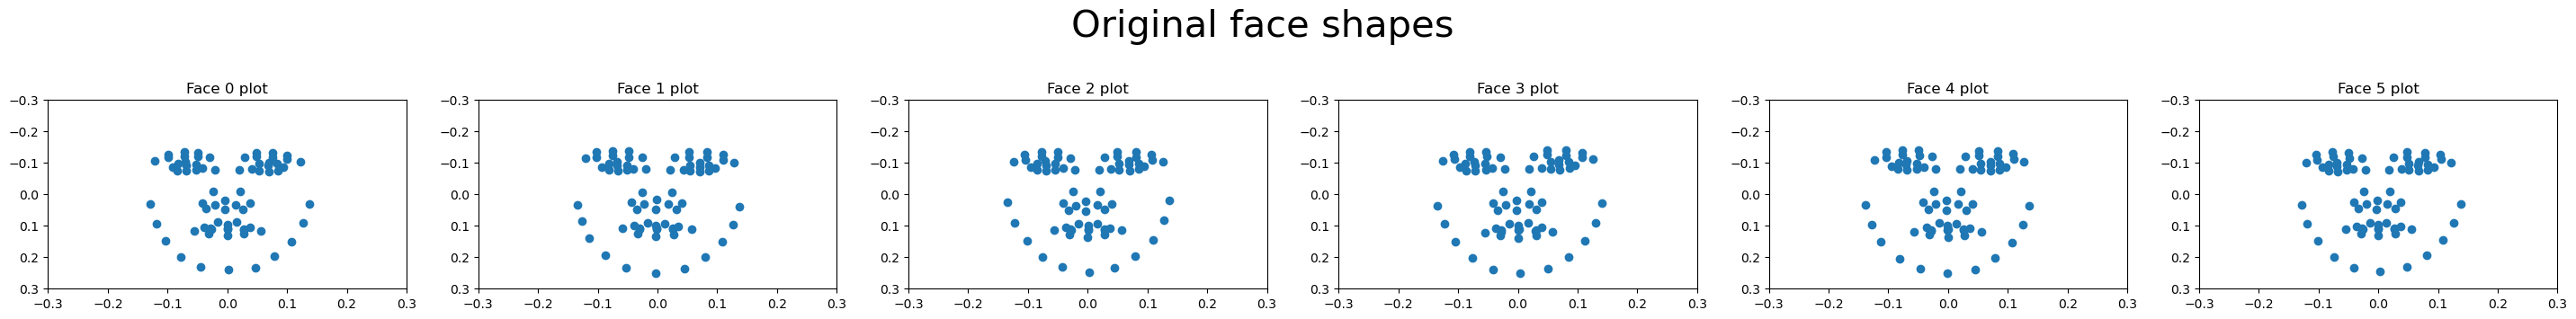

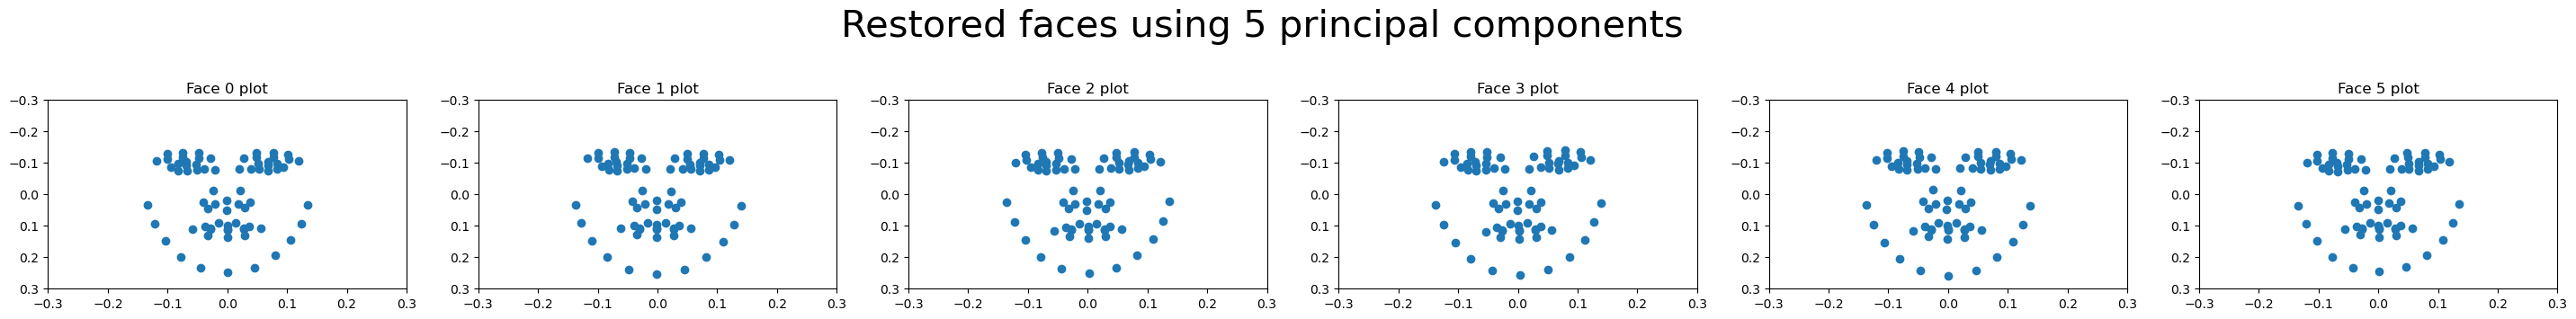

In [3]:
# 1
def get_principal_components(X):
    """Calculates principle components for X.

    Args:
        X: The dataset. An NxD array were N are the number of samples and D are
        the number of features.

    Returns:
        Tuple (components, eigenvalues, mu) where components is a DxD matrix of
        principle components, eigenvalues is a D-element vector of
        corresponding eigenvalues, and mu is a D-element array containing the mean
        vector.
    """
    # Calculate the mean vector
    mu = np.mean(X, axis=0)
    # Center the data by subtracting the mean
    X_centered = X - mu
    # Compute the covariance matrix
    C = np.cov(X_centered, rowvar=False)
    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(C)
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    # Return the principal components (eigenvectors), eigenvalues, and mean vector
    return eigenvectors, eigenvalues, mu


# 2, 3 and 4
# Get the principal components for the dataset and transform the faces to feature space.
comp, val, mu = get_principal_components(shapes)

# Cumulative proportional variance here
cumulative_variance = np.cumsum(val) / np.sum(val)

# Find the number of components needed for each threshold
thresholds = [0.50, 0.60, 0.80, 0.95]
components_needed = [np.searchsorted(cumulative_variance, t) + 1 for t in thresholds]
components_needed_dict = dict(zip(thresholds, components_needed))

print("Components needed for each threshold:", components_needed_dict)


# selecting 5 components 
n_components = 5
retained_variance = cumulative_variance[n_components - 1]  # Since indices are zero-based
print(f"Variance retained with {n_components} components: {retained_variance:.2f}")


# 5
def transform_to_latent_space(X, principle_components, mu):
    """Transforms X to an k-dimensional space where k is the number of
    principle_components.

    Args:
        X: The dataset. An NxD array were N are the number of samples and D are
        the number of features.
        principle_components: An Dxk matrix containing the principle
        components.
        mu: A D-element array containing the mean vector.

    Returns:
        A Nxk array describing the transformed data.
    """
    # Center the data by subtracting the mean
    X_centered = X - mu
    # Project the centered data onto the principal components
    latent_space_data = np.dot(X_centered, principle_components)
    return latent_space_data

    
# 6  
def transform_from_latent_space(v, principle_components, mu):
    """Reverses the dimensionality reduction of v, a Nxk matrix where
    k is the number of principle components. The result is a NxM matrix.

    Args:
        v: The transformed dataset with size Nxk.
        principle_components: An Dxk matrix containing the principle
        components.
        mu: A Mx1 matrix containing the mean vector.

    Returns:
        An NxD array reconstruction of the original feature vectors X.
    """
    # Reconstruct the data by projecting back to data space and adding the mean
    reconstructed_data = np.dot(v, principle_components.T) + mu
    return reconstructed_data

    
# 7     
used = comp[:, :n_components]

# Plot original face shapes
plot_many_faces(shapes[:6], "Original face shapes")

# Transform to latent space and back to data space
transformed = transform_to_latent_space(shapes[:6], used, mu)
restored = transform_from_latent_space(transformed, used, mu)

# Plot reconstructed face shapes
plot_many_faces(restored, "Restored faces using 5 principal components")



## Task 2 reflection

**Reconstruction error**

Since we keep around 87% of the variation, there is no outstanding difference between the original and the reconstructed faces. However, when you look closely you can see small differences in the points's locations.


## Using PCA for shape generation
The principal components can be used to generate new samples $\mathbf{x}$ in data space by transforming a point in latent space according to 
$$\mathbf{x} = \Phi_{k} a + \mu$$
 where $\Phi_{k}$ is the matrix of k eigenvectors, $\mathbf{a}\in\mathbb{R}^{k}$ is a vector in latent space, and $\mu\in\mathbb{R}^{D}$ is the mean vector of the original data features in  the data space.

$$

{\Phi_k} = \begin{bmatrix} | & | & & | \\ {v}_1 & {v}_2 & \cdots & {v}_k \\ | & | & & | \end{bmatrix}

$$
The variance of the data in a given direction can be used to constrain the values of the elements of the vector $\mathbf{a}$ in latent space, assuming that the data follows a (multivariate) normal distribution. In a multivariate normal distribution each direction $v_i$ is also normally distributed. Each element $a_i$ can be constrained to be within the observed variance in direction $v_i$. The variance $\sigma^2$ in the direction of $v_i$ is given by the eigenvalue $\lambda_i$, so the standard deviation is  $\sigma_i = \sqrt{\lambda_i}$.
In a 1D normal distribution (with mean $\mu$ and standard deviation $\sigma$), the area under the Gaussian curve between $\pm 3\sigma$ contains $99.7\%$ of the data (see [Figure 1](#normal) ). Thus, constraining each element $a_i$ to the interval $[-3\sigma_i, 3\sigma_i]$ will cover $99.7\%$ of the variance in the direction of $v_i$. 
<div class="has-text-centered">
<figure class="image is-inline-block" id="normal">

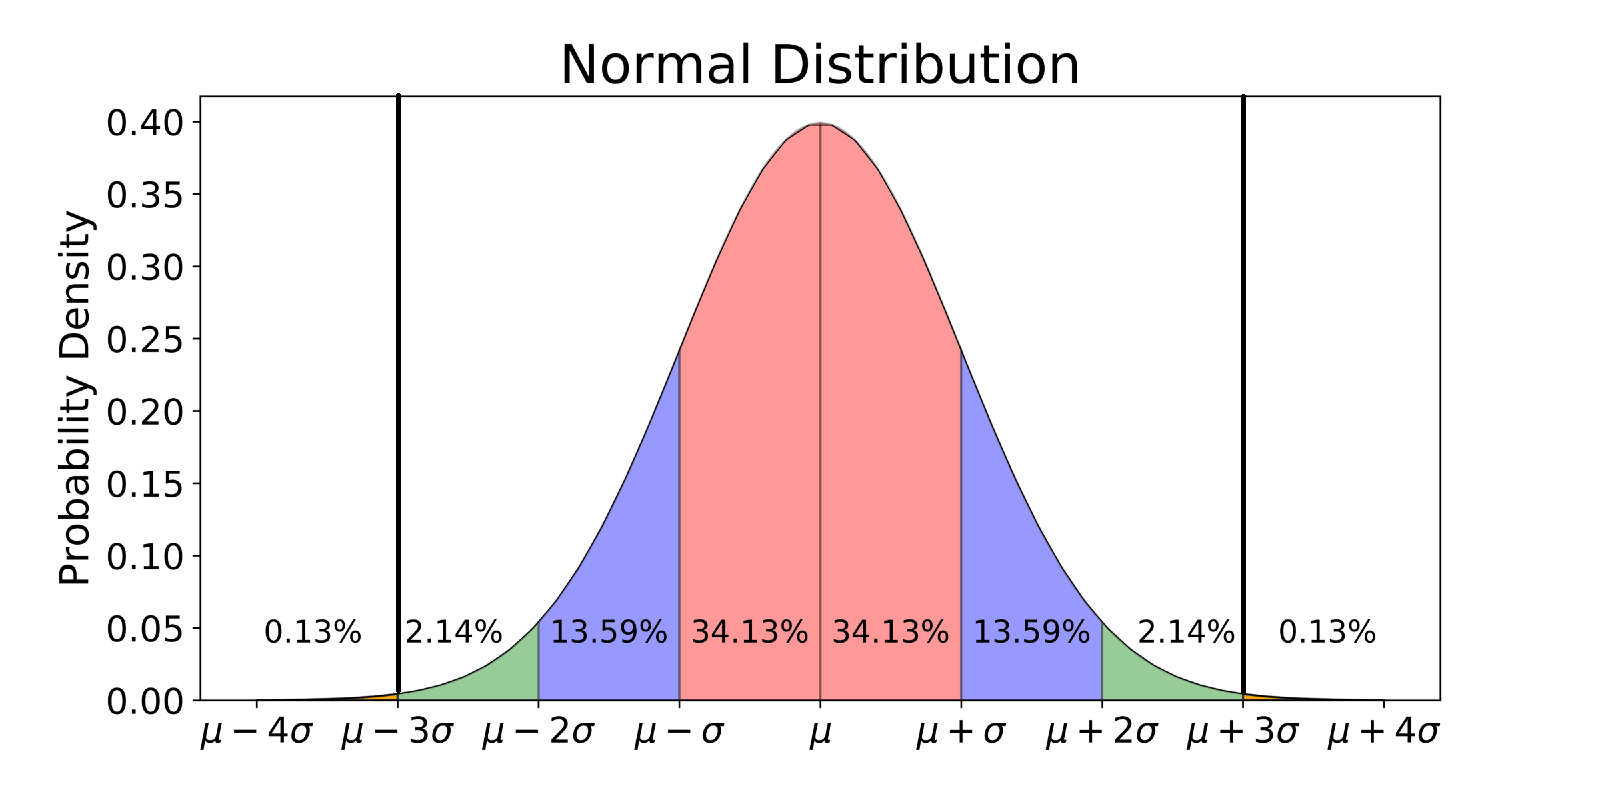

<figcaption class="figure-caption has-text-centered">Figure 1: Illustration of a normal distribution. The vertical lines mark the region covering $99.7\%$ of the variance. The shaded regions indicate the
area of the distribution covered by 1, 2, 3, and 4, standard deviations
($\sigma$) respectively.
</figcaption>
</figure>
</div>

---
**Task 3 (medium): Base face👩‍💻**
1. **Generate vectors:** run the cell below to create the zero vector in latent space, i.e. $\mathbf{a} = [0, 0, \dots, 0]\in\mathbb{R}^5$.
2. **Shape generation:** use $\mathbf{x} = \mathbf{\Phi} \mathbf{a} + \mathbf{\mu}$ to generate a face (vector in real space) from the vector $\mathbf{a}$. Use the `plot_face`
 function to visualise the generated face.
3. Change the elements of $\mathbf{a}$ to the values below, where $\lambda_i$ is the i-th eigenvalue and plot the resulting shapes for each modification:    - $\mathbf{a} = [\lambda_1,0, 0, 0, 0]$ $\in\mathbb{R}^5$? 
    - $\mathbf{a} = [0,-3\lambda_2, 0, 0, 0]$ $\in\mathbb{R}^5$?




---

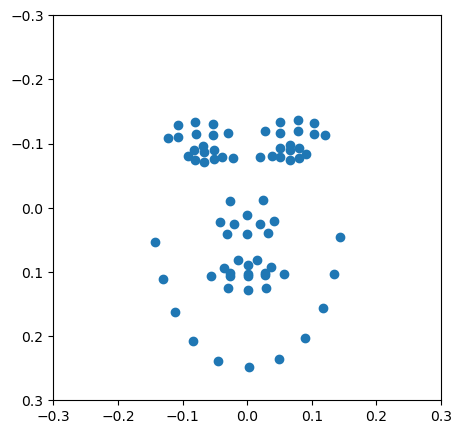

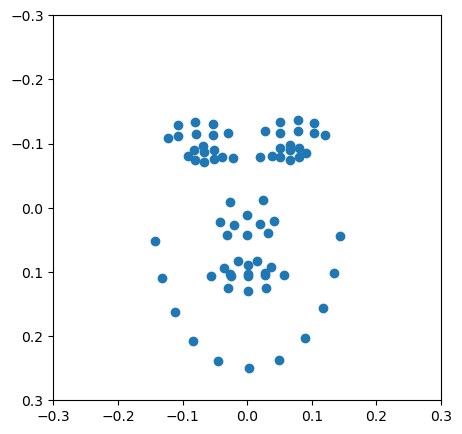

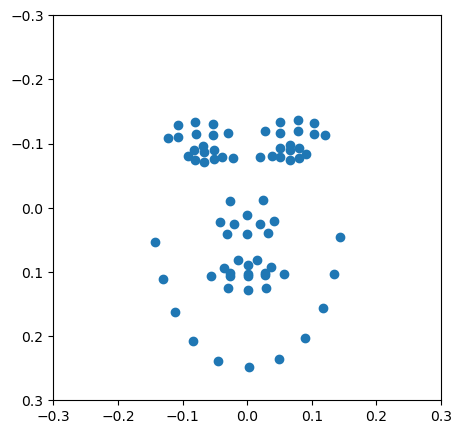

In [4]:
#1 Generate Zero Vector in Latent Space
a_zero_vector = np.array([0,0,0,0,0])

#2 Generate a Face Shape from the Zero Vector
Phi_k = comp[:, :5] # first 5 principal components

# Generate a face in data space from the zero vector in latent space
base_face = transform_from_latent_space(a_zero_vector.reshape(1, -1), Phi_k, mu)
plot_face(base_face[0])
# Reflection: The first generated face corresponds to the mean shape, as it uses a zero vector in latent space.

#3.3 Generate and Plot New Faces by Modifying the Vector a

# Set the first component of a to lambda_1
a_lambda1 = np.array([val[0],0,0,0,0])
# Generate the corresponding face in data space
face_lambda1 = transform_from_latent_space(a_lambda1.reshape(1, -1), Phi_k, mu)
plot_face(face_lambda1[0])

#3.2 Generate and Plot New Faces by Modifying the Vector a, setting the second element to -3 * sqrt(lambda_2)
a_neg3lambda2 = np.array([0,0,0,0,0])
a_neg3lambda2[1] = -3 * val[1]

# Generate the corresponding face in data space
face_neg3lambda2 = transform_from_latent_space(a_neg3lambda2.reshape(1, -1), Phi_k, mu)
plot_face(face_neg3lambda2[0])




---
**Task 4 (medium): Base face reflections 💡**
1. Use $\mathbf{x} = \Phi_{k} a + \mu$ to explain what the vector $a \in R^5$ represents if     - $\mathbf{a}= [0,0,0,0,0]$?
    - $\mathbf{a} = [\lambda_1,0, 0, 0, 0]$? 
    - $\mathbf{a} = [0,-3\lambda_2, 0, 0, 0]$?


2. Describe what face is generated and why.


---

## Task 4 reflection

**What the vector 𝑎 ∈ R^5 represents for each case:**

1. $\mathbf{a} = [0,0,0,0,0]$ represents a face with no variations. The mean shape is generated. Essentially, this is the "average" shape across all samples.
2. $\mathbf{a} = [\lambda_1,0, 0, 0, 0]$ represents a face with a shift of 1 unit of variance in the first eigenvectors direction. This is also the most significant direction of variation in the dataset.
3. $\mathbf{a} = [0,-3\lambda_2, 0, 0, 0]$ represents a face with a shift of -3 units of variance in the second eigenvectors direction. 

**What face is generated and why**

A more thorough answer is given in task 5

## Investigating principal components
The following tasks are about investigating properties of principal components.

---
**Task 5 (medium): Investigate variations in latent space👩‍💻**
1. **Varying the 1st component:** Let $\mathbf{a} \in \mathbb{R^5}$ be a vector in the latent space. Generate 5 different vectors where only the first element, $a_1$, varies, while the remaining elements, $a_2, a_3, a_4, a_5$, are set to 0. Use `np.linspace`
 to generate 5 evenly spaced values for $a_1$ in the interval $[-3\sigma_1, 3\sigma_1]$. For each value of $a_1$, generate a corresponding face and display all 5 faces in a plot. 

2. **More components:** Do the same for each of the remaining four components, i.e. $a_2$-$a_5$ leaving the others as 0. 

3. **Component analysis:** Describe how each principal component changes the face shape (for example, the first component may change the length of the face). 



---

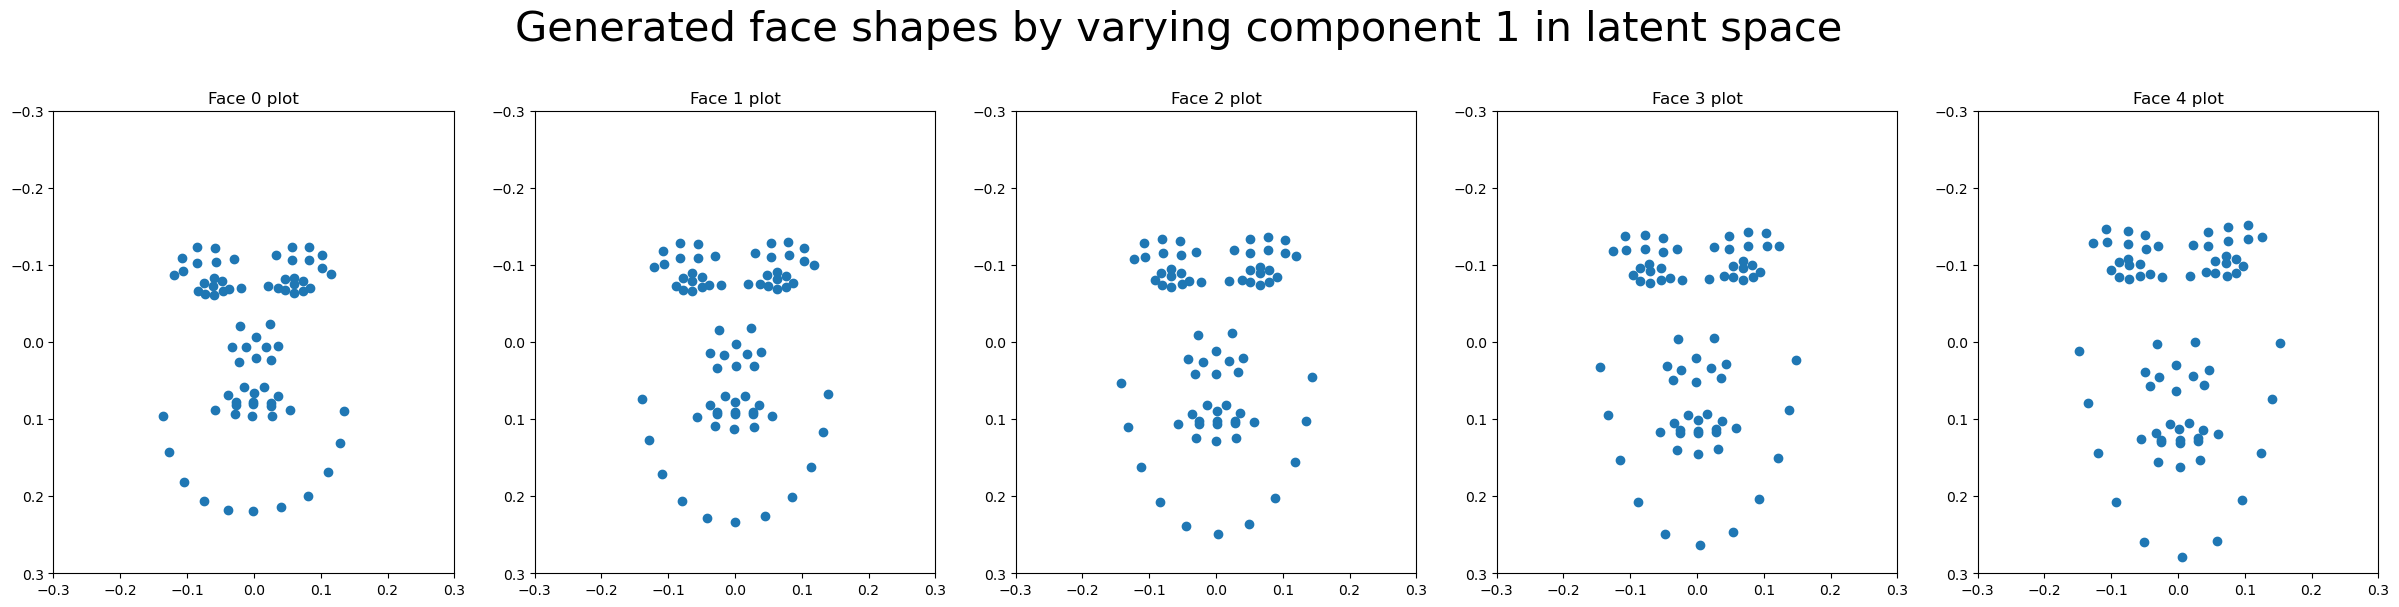

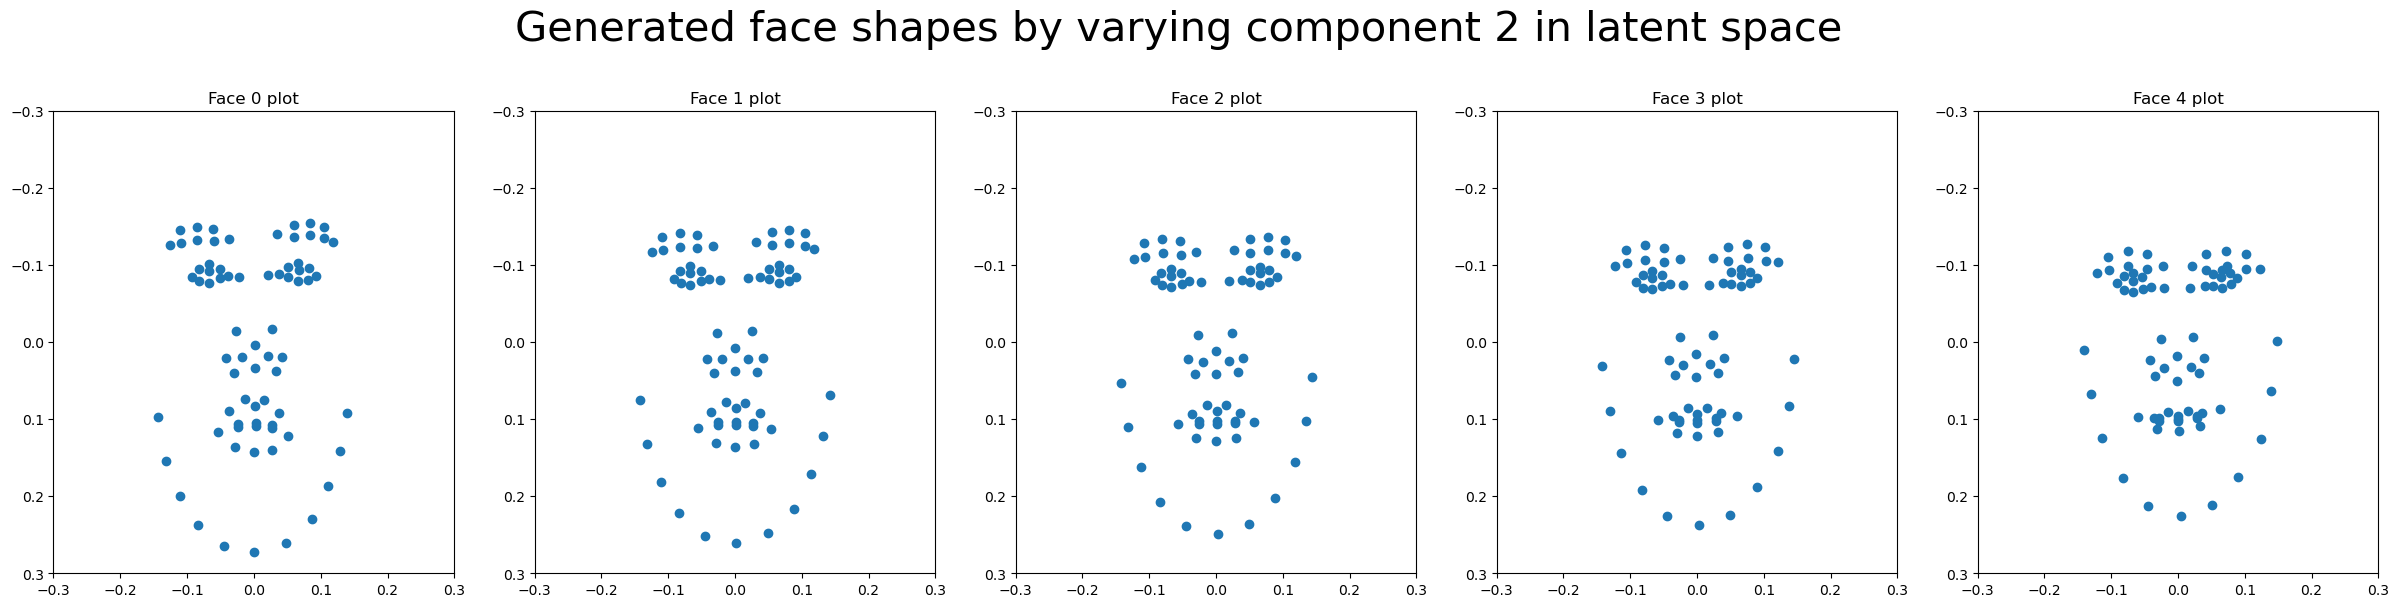

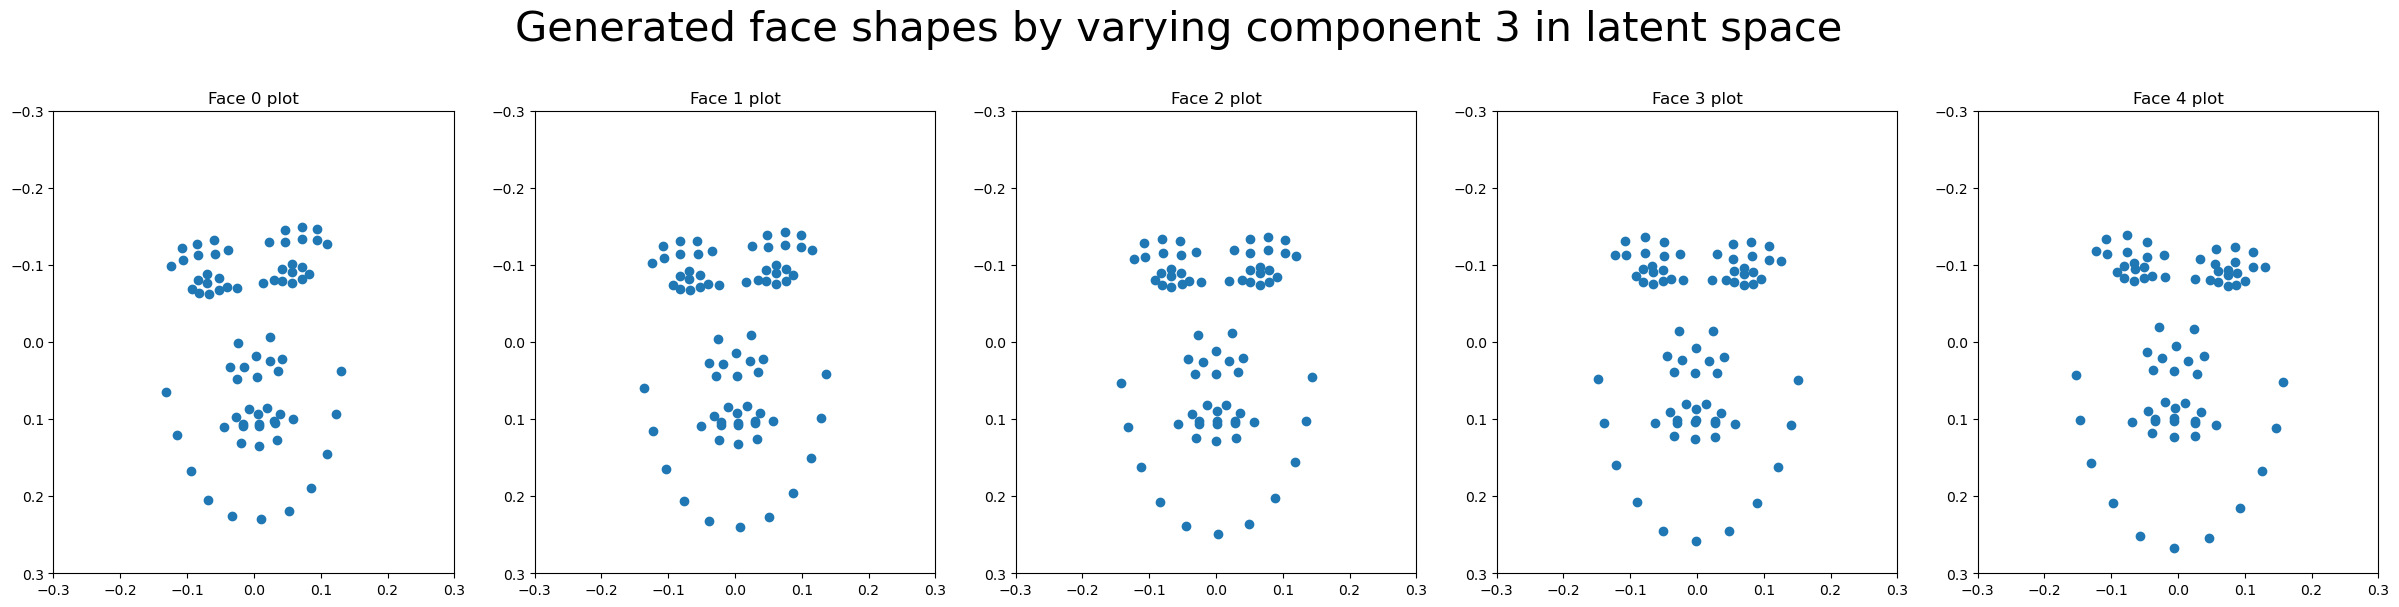

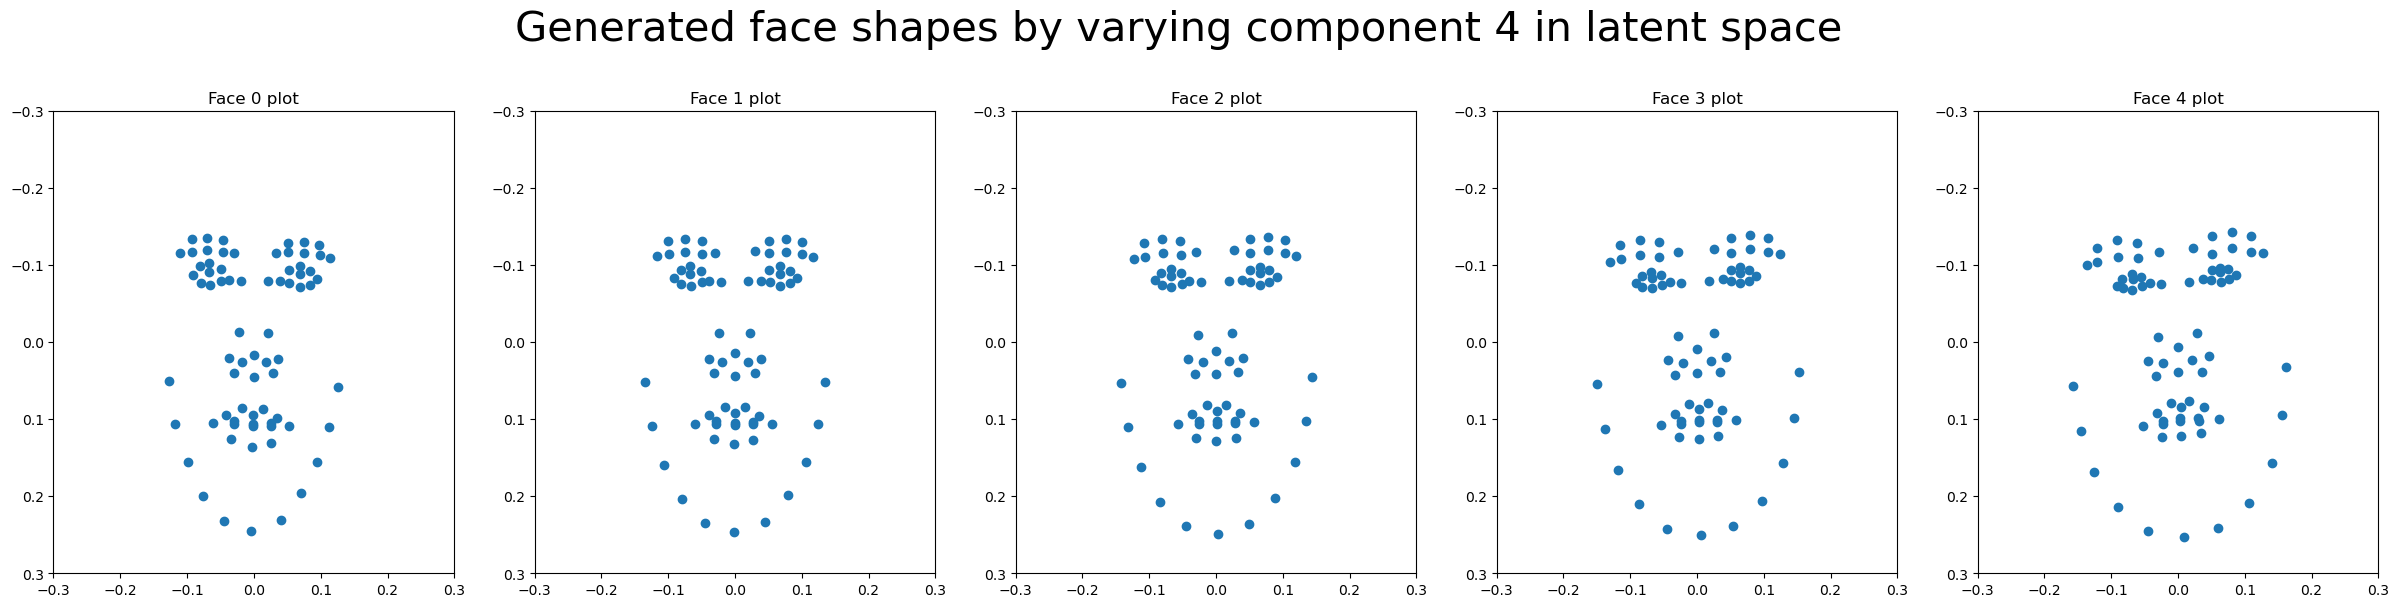

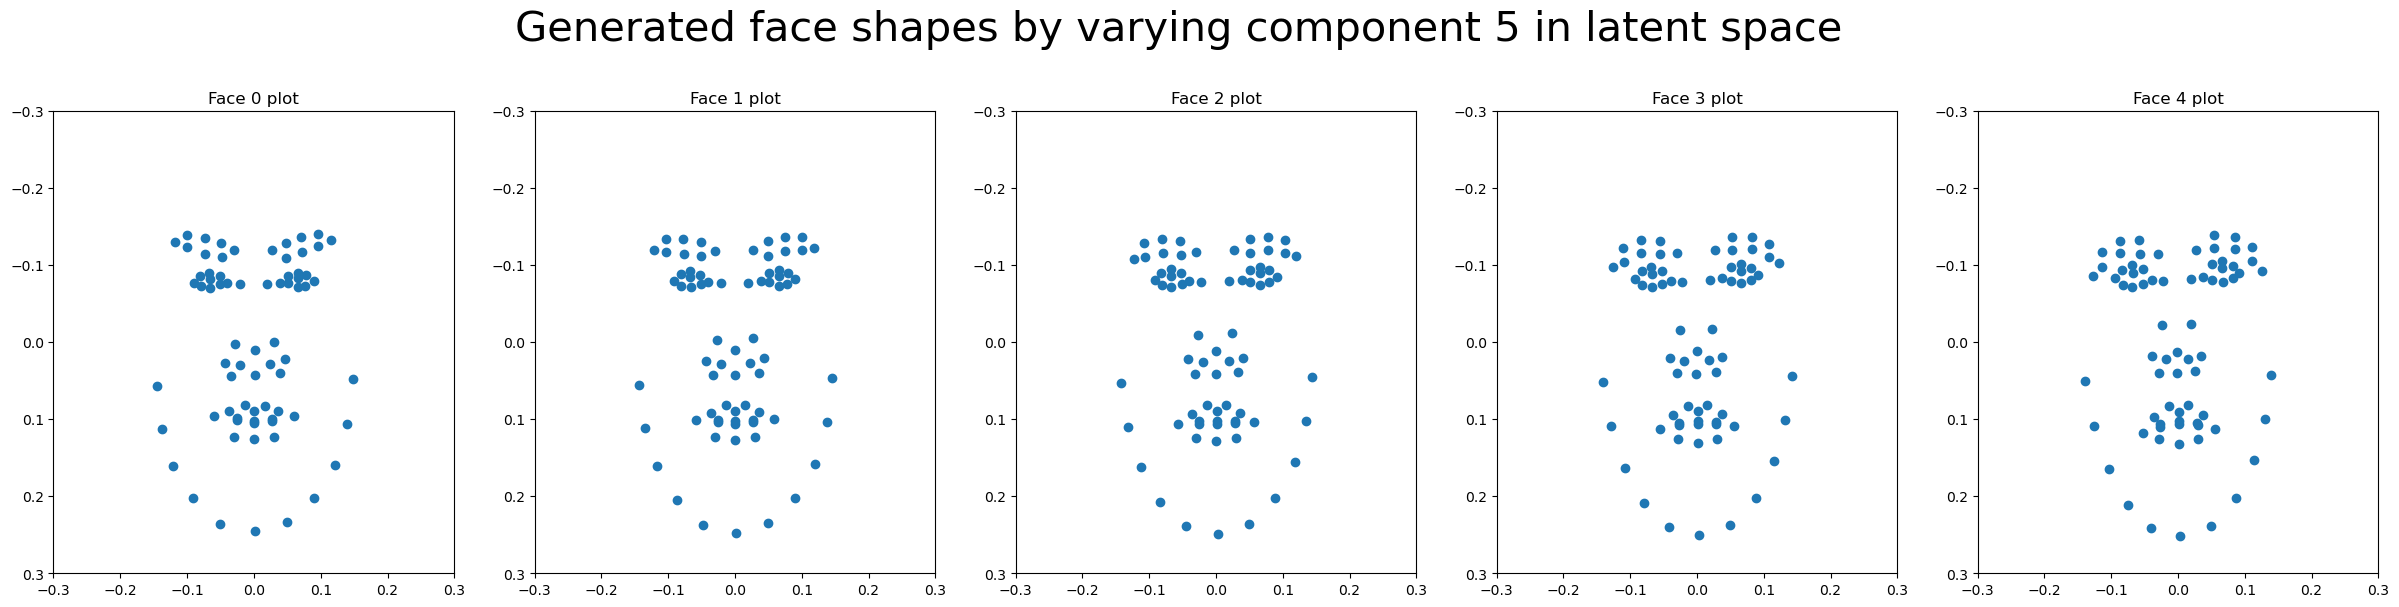

In [5]:
# 1 and 2. Varying the first five components in the latent space
std_values = [np.sqrt(val[i]) for i in range(5)]
gen_faces_all = []

for i in range(5):
    # [-3*std_i, 3*std_i]
    ai_values = np.linspace(-3 * std_values[i], 3 * std_values[i], num=5)
    gen_faces_component = []
    
    for ai in ai_values:
        a = np.zeros(5)
        a[i] = ai  # Set only the i-th component
        face = transform_from_latent_space(a.reshape(1, -1), Phi_k, mu)
        gen_faces_component.append(face[0])
    
    gen_faces_all.append(gen_faces_component)

# Plot faces for each component variation
for idx, faces in enumerate(gen_faces_all):
    plot_many_faces(faces, f"Generated face shapes by varying component {idx+1} in latent space")

## The plots below we made for our own overview to help answering the tasks

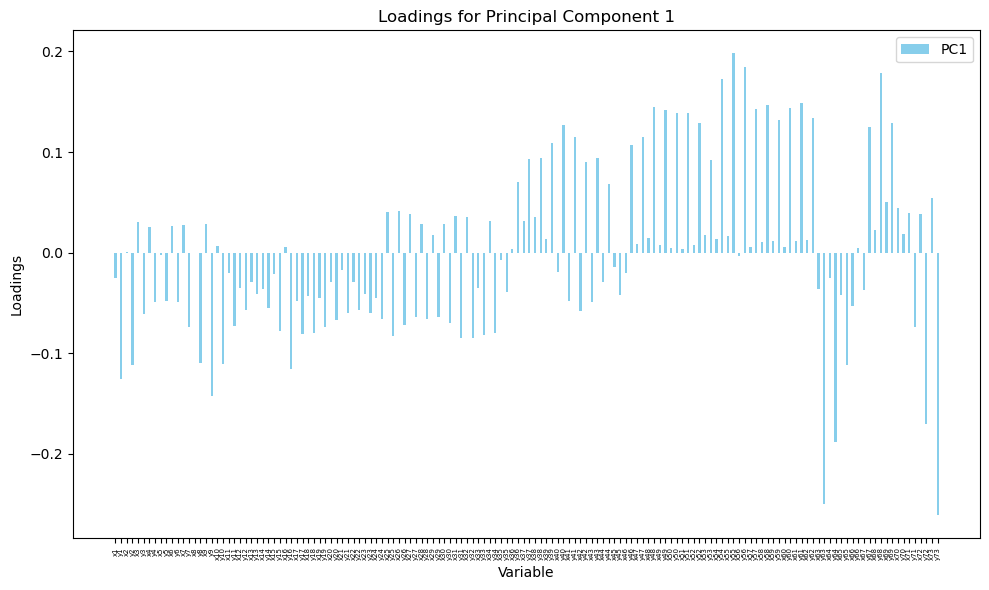

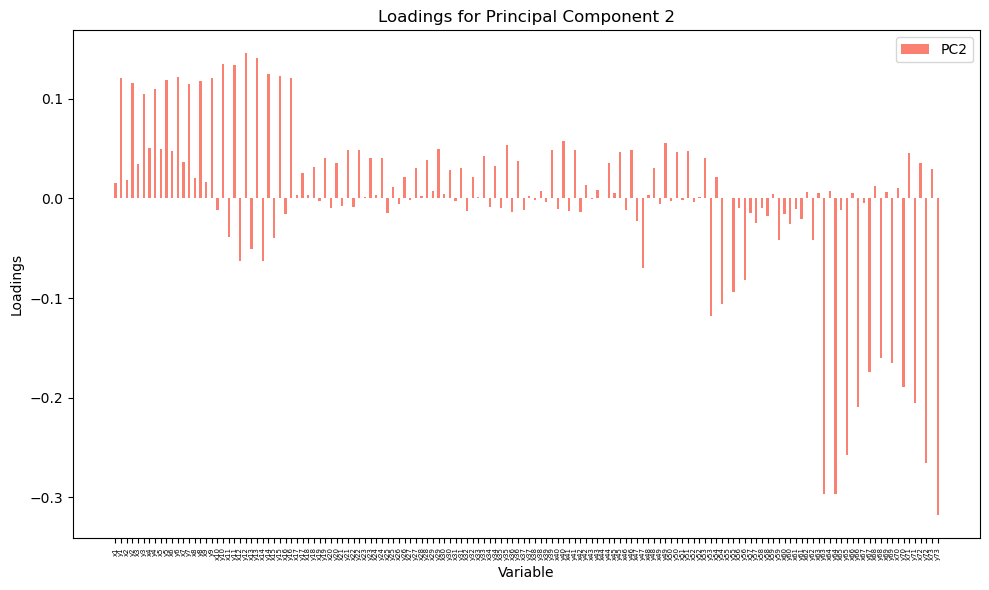

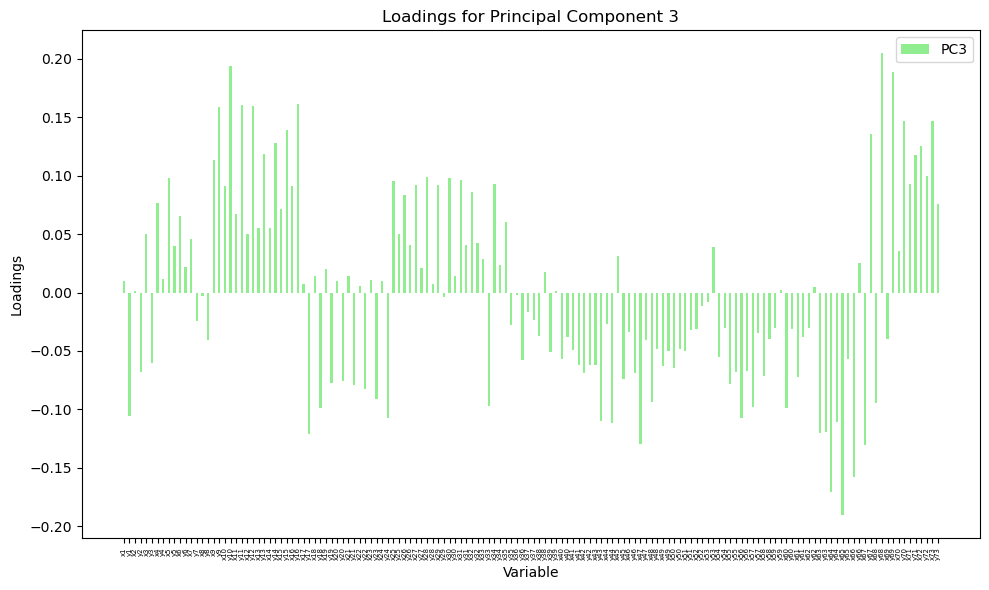

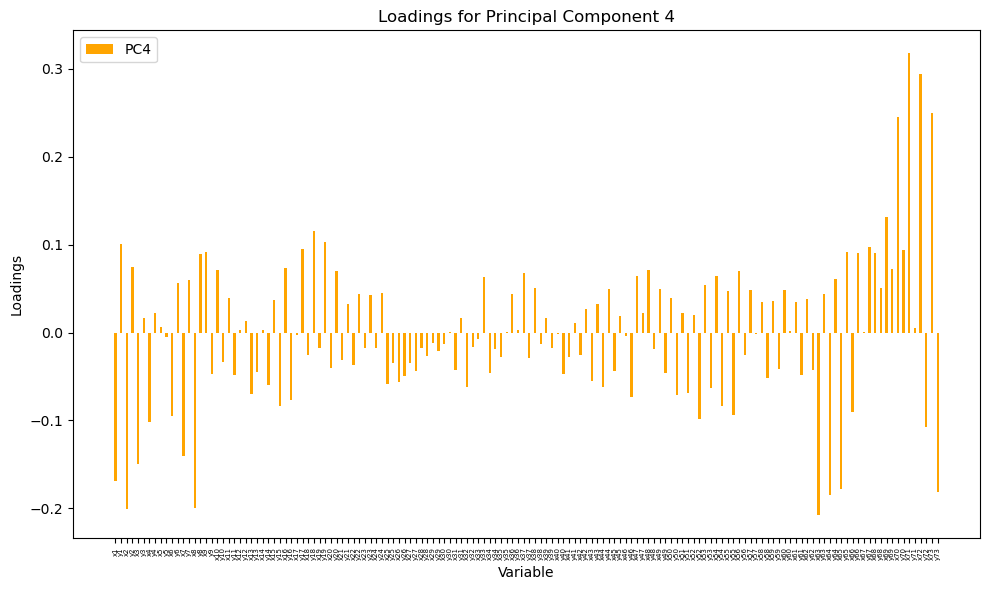

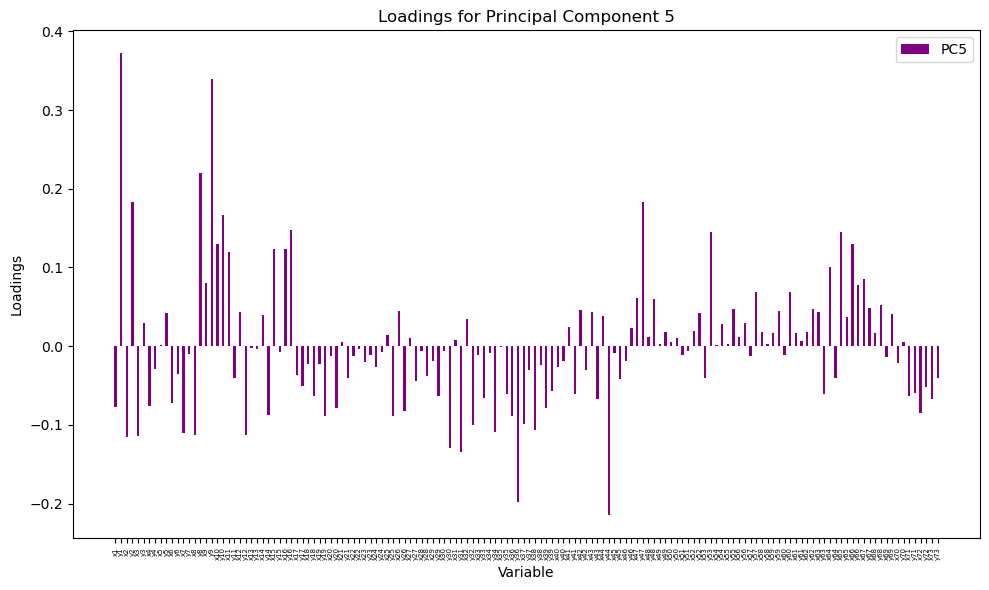

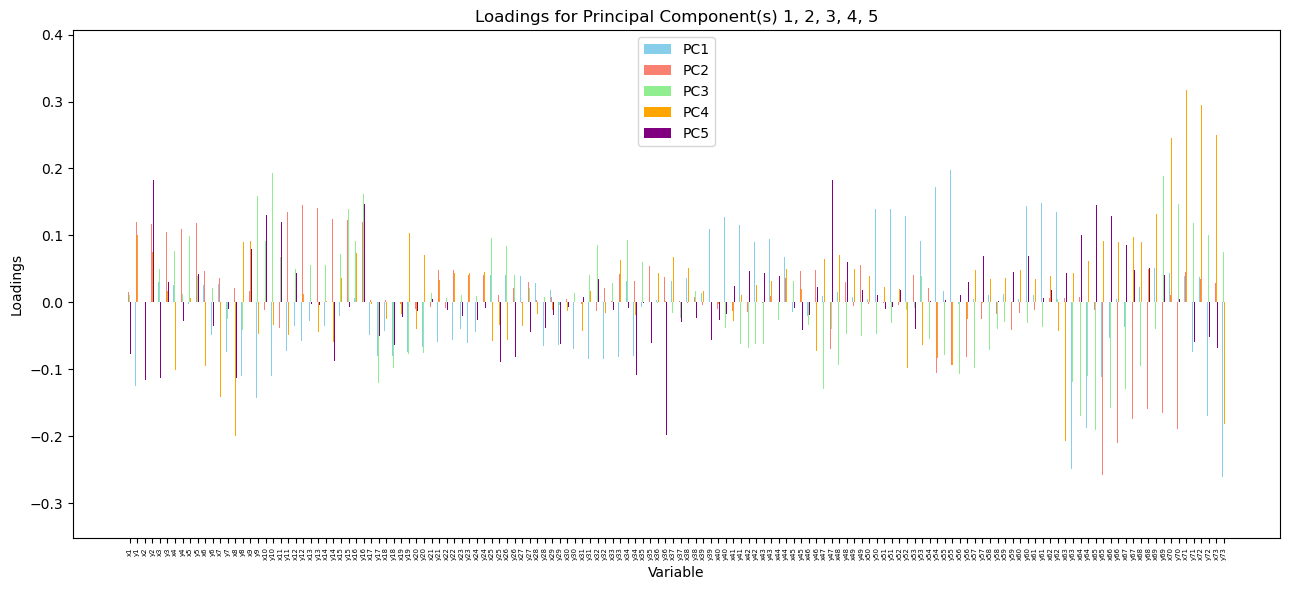

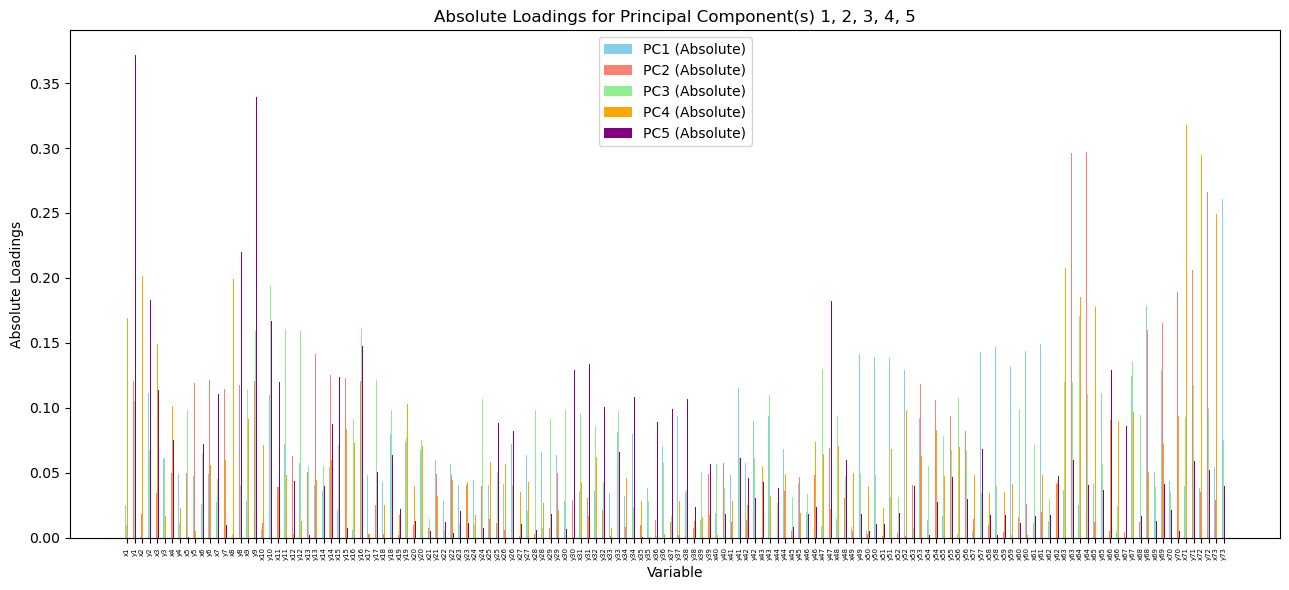

In [6]:
#Slightly modified from week 10 pca_utils.py
def plot_pca_loadings(
    mixing_params,
    num_variables,
    bar_width=0.4,
    colors=None,
    component_indices=[1, 2, 3, 4, 5],  # First five PCs
    show_individual=True,
    show_combined=True,
    save_plots=False,
    save_dir='plots',
    file_format='png'
):
    """
    Plots the loadings for specified principal components as bar charts.

    Parameters:
    -----------
    mixing_params : numpy.ndarray
        A 2D array of PCA loadings with shape (num_variables, num_components).
    
    num_variables : int
        Number of variables in the dataset.

    bar_width : float, default=0.4
        Width of the bars in the bar plots.

    colors : list of str, optional
        List of colors for the principal components. If None, colors are auto-generated using a color map.

    component_indices : list of int, default=[1, 2, 3, 4, 5]
        Specific principal components to plot (1-based indexing). Default is the first five PCs.

    show_individual : bool, default=True
        Whether to plot individual principal components as separate bar charts.

    show_combined : bool, default=True
        Whether to plot a combined bar chart with multiple principal components side by side.

    save_plots : bool, default=False
        Whether to save the generated plots to files.

    save_dir : str, default='plots'
        Directory where the plots will be saved if `save_plots` is True.

    file_format : str, default='png'
        Format to save the plots (e.g., 'png', 'jpg', 'pdf').

    Returns:
    --------
    None
        Displays the plots.
    """
    component_indices_zero_based = [idx - 1 for idx in component_indices]
    num_components_to_plot = len(component_indices_zero_based)

    # Set default colors if not provided or insufficient
    if colors is None or len(colors) < num_components_to_plot:
        cmap = cm.get_cmap('tab10')
        colors = [cmap(i % cmap.N) for i in range(num_components_to_plot)]

    # Generate variable labels as x1, y1, x2, y2, ..., up to the total number of variables
    variable_labels = [f'x{i//2 + 1}' if i % 2 == 0 else f'y{i//2 + 1}' for i in range(num_variables)]


    # Plot individual principal components
    if show_individual:
        for i, comp_idx in enumerate(component_indices_zero_based):
            plt.figure(figsize=(10, 6))
            x_positions = np.arange(num_variables)
            plt.bar(x_positions, mixing_params[:, comp_idx], width=bar_width, color=colors[i], label=f'PC{comp_idx + 1}')
            plt.xlabel('Variable')
            plt.ylabel('Loadings')
            plt.title(f'Loadings for Principal Component {comp_idx + 1}')
            plt.xticks(np.arange(num_variables), variable_labels, rotation=90, fontsize=5) 
            plt.legend(loc='best')
            plt.tight_layout()
            if save_plots:
                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                plt.savefig(f"{save_dir}/PC{comp_idx + 1}_Loadings.{file_format}")
            plt.show()

    # Plot combined principal components
    if show_combined:
        plt.figure(figsize=(13, 6))
        for i, (comp_idx, color) in enumerate(zip(component_indices_zero_based, colors)):
            adjusted_positions = np.arange(num_variables) - bar_width/2 + i*(bar_width / num_components_to_plot)
            plt.bar(adjusted_positions, mixing_params[:, comp_idx], width=bar_width/num_components_to_plot, 
                    color=color, label=f'PC{comp_idx + 1}')
        plt.xlabel('Variable')
        plt.ylabel('Loadings')
        plt.title(f"Loadings for Principal Component(s) {', '.join(map(str, component_indices))}")

        plt.legend(loc='best')
        plt.xticks(np.arange(num_variables), variable_labels, rotation=90, fontsize=5) 

        plt.tight_layout()
        if save_plots:
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            plt.savefig(f"{save_dir}/Combined_PCs_Loadings.{file_format}")
        plt.show()
   
    # Plot combined absolute loadings
    if show_combined:
        plt.figure(figsize=(13, 6))
        for i, (comp_idx, color) in enumerate(zip(component_indices_zero_based, colors)):
            adjusted_positions = np.arange(num_variables) - bar_width/2 + i*(bar_width / num_components_to_plot)
            plt.bar(adjusted_positions, np.abs(mixing_params[:, comp_idx]), width=bar_width/num_components_to_plot, 
                    color=color, label=f'PC{comp_idx + 1} (Absolute)')
        plt.xlabel('Variable')
        plt.ylabel('Absolute Loadings')
        plt.title(f"Absolute Loadings for Principal Component(s) {', '.join(map(str, component_indices))}")
        plt.legend(loc='best')
        plt.xticks(np.arange(num_variables), variable_labels, rotation=90, fontsize=5)
        plt.tight_layout()
        if save_plots:
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            plt.savefig(f"{save_dir}/Combined_PCs_Absolute_Loadings.{file_format}")
        plt.show()

plot_pca_loadings(
    mixing_params=comp,
    num_variables=comp.shape[0], 
    bar_width=0.4,
    colors=['skyblue', 'salmon', 'lightgreen', 'orange', 'purple'],
    component_indices=[1, 2, 3, 4, 5],
    show_individual=True,
    show_combined=True,
    save_plots=False
)

In [7]:
def calculate_highest_pc_per_pair(eigenvectors, eigenvalues, num_components=5):
    """
    Calculates which principal component has the highest absolute sum of loadings for each (x, y) pair.
    
    Args:
        eigenvectors (numpy.ndarray): Matrix of eigenvectors (shape: num_variables, num_components).
        eigenvalues (numpy.ndarray): Array of eigenvalues corresponding to each component.
        num_components (int): Number of principal components to include in the calculation (default: 5).

    Returns:
        dict: A dictionary where the keys are variable pair indices (1-based index), 
              and the values are the principal component ('PCx') with the highest loading sum for that pair.
    """
    # Calculate loadings by scaling eigenvectors with sqrt of eigenvalues
    loadings = eigenvectors * np.sqrt(eigenvalues)

    # Initialize a dictionary to store the highest PC for each variable pair
    highest_pc_per_pair = {}

    # Iterate over each (x_i, y_i) pair
    for i in range(0, loadings.shape[0], 2):
        pair_idx = (i // 2) + 1
        max_sum = 0
        max_pc = None

        # Calculate the absolute sum of loadings for each principal component for this pair
        for pc_idx in range(num_components):
            x_loading = abs(loadings[i, pc_idx])    # x_i loading
            y_loading = abs(loadings[i + 1, pc_idx])  # y_i loading
            loading_sum = x_loading + y_loading

            # Update if this PC has a higher sum for the pair
            if loading_sum > max_sum:
                max_sum = loading_sum
                max_pc = f"PC{pc_idx + 1}"

        # Store the PC with the highest loading sum for this variable pair
        highest_pc_per_pair[pair_idx] = max_pc

    return highest_pc_per_pair

# Example usage
# Assuming `comp` contains eigenvectors and `val` contains eigenvalues
highest_pc_dict = calculate_highest_pc_per_pair(comp, val)
print(highest_pc_dict)


{1: 'PC5', 2: 'PC4', 3: 'PC2', 4: 'PC2', 5: 'PC2', 6: 'PC2', 7: 'PC2', 8: 'PC4', 9: 'PC1', 10: 'PC3', 11: 'PC2', 12: 'PC2', 13: 'PC2', 14: 'PC2', 15: 'PC2', 16: 'PC3', 17: 'PC1', 18: 'PC1', 19: 'PC1', 20: 'PC1', 21: 'PC1', 22: 'PC1', 23: 'PC1', 24: 'PC1', 25: 'PC1', 26: 'PC1', 27: 'PC1', 28: 'PC1', 29: 'PC1', 30: 'PC1', 31: 'PC1', 32: 'PC1', 33: 'PC1', 34: 'PC1', 35: 'PC2', 36: 'PC5', 37: 'PC1', 38: 'PC1', 39: 'PC1', 40: 'PC1', 41: 'PC1', 42: 'PC1', 43: 'PC1', 44: 'PC1', 45: 'PC3', 46: 'PC1', 47: 'PC1', 48: 'PC1', 49: 'PC1', 50: 'PC1', 51: 'PC1', 52: 'PC1', 53: 'PC2', 54: 'PC1', 55: 'PC1', 56: 'PC1', 57: 'PC1', 58: 'PC1', 59: 'PC1', 60: 'PC1', 61: 'PC1', 62: 'PC1', 63: 'PC1', 64: 'PC2', 65: 'PC2', 66: 'PC2', 67: 'PC1', 68: 'PC1', 69: 'PC1', 70: 'PC2', 71: 'PC2', 72: 'PC2', 73: 'PC1'}


C:\Users\jgrum\AppData\Local\Temp\ipykernel_24316\4110723677.py:15: RuntimeWarning: invalid value encountered in sqrt
  loadings = eigenvectors * np.sqrt(eigenvalues)


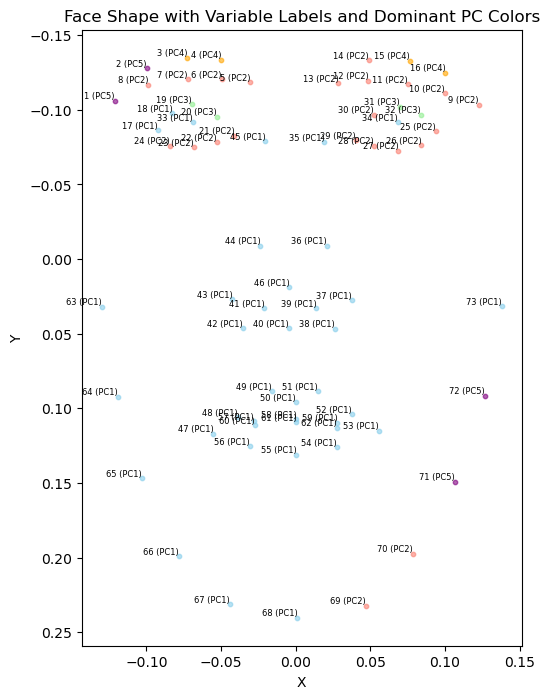

In [8]:
def plot_face_with_labels(face_points, highest_pc_per_pair, colors=None):
    """
    Plots a scatterplot of face points and labels each point with its variable number.
    Points are colored based on the principal component with the highest contribution.
    
    Args:
        face_points (numpy.ndarray): A 1D array of shape (2 * N,) where each consecutive pair of values
                                     represents an (x, y) coordinate.
        highest_pc_per_pair (dict): Dictionary where keys are variable indices (1-based index) and values
                                    are the principal component ("PCx") with the highest loading sum for that pair.
        colors (dict): A dictionary mapping each principal component ("PC1", "PC2", etc.) to a color.
                       Default is {'PC1': 'skyblue', 'PC2': 'salmon', 'PC3': 'lightgreen', 'PC4': 'orange', 'PC5': 'purple'}.
    """
    # Set default colors if none are provided
    if colors is None:
        colors = {
            'PC1': 'skyblue',
            'PC2': 'salmon',
            'PC3': 'lightgreen',
            'PC4': 'orange',
            'PC5': 'purple'
        }
    
    # Reshape face_points to (N, 2) if it's a flat array
    if face_points.ndim == 1:
        face_points = face_points.reshape(-1, 2)

    plt.figure(figsize=(8, 8))
    
    # Plot each point with the color corresponding to its highest contributing PC
    for i, (x, y) in enumerate(face_points):
        pair_idx = i // 2 + 1  # Calculate the variable pair index (1-based)
        label = f"{i+1}"
        
        # Determine the color based on the highest contributing PC for this pair
        pc_label = highest_pc_per_pair.get(pair_idx, None)  # Get the PC label or None if not in dict
        color = colors.get(pc_label, 'gray')  # Default to 'gray' if PC label is not in colors
        
        # Add the PC label to the point's text if available
        if pc_label:
            label += f" ({pc_label})"
        
        # Plot the point
        plt.scatter(x, y, color=color, s=10, alpha=0.6)
        plt.text(x, y, label, fontsize=6, ha='right', va='bottom')
    
    # Set equal scaling, invert y-axis, and add labels
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().invert_yaxis()  # Flip the y-axis
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Face Shape with Variable Labels and Dominant PC Colors")
    plt.show()

# Example usage
# Assuming `shapes[0]` contains the first face shape and `highest_pc_dict` is the dictionary generated previously
plot_face_with_labels(shapes[0], highest_pc_dict)


## Task 5 reflections

**3. Component Analysis**
* PC1: Chin vertical stretched (small to elongated). As seen on the last scatter plot, PC1 also seems to be the dominant parameter for the points in the nose and mouth. This is to be expected, as PC1 is the component with most variance, thus naturally affects the most points.
* PC2: Distance between eyebrows and eyes (far to close). The scatter plot also shows a lot og PC2-affected points around the eyes.
* PC3: skew/lean face left right (left to right). This affects many of the points, but not enough to be the dominant parameter for most of them.
* PC4: chin width (narrow to broad)
* PC5: Orientiation of eyebrows (angry to surprised)

## Interpolating between shapes
The following example shows how to interpolate two vectors.

Interpolation is a method used to create new data points within the range of a set of known data points. In simple terms, it "fills in the gaps" between two points by estimating intermediate values.

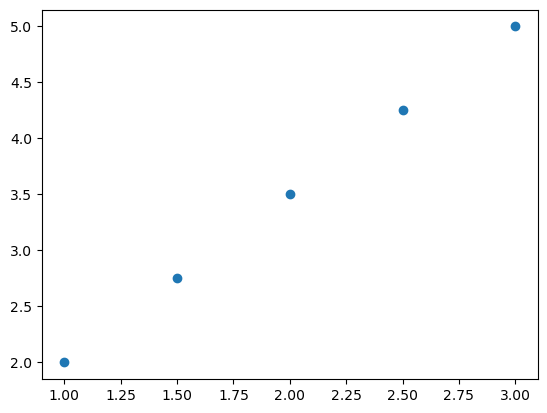

In [9]:
# #Template for doing interpolation between two (2D)- points 
d = np.linspace(np.array([1, 2]), np.array([3, 5]), num=5)
plt.scatter(d[:, 0], d[:, 1])


---
**Task 6 (medium): Interpolation between two faces👩‍💻**
**Shape Interpolation:**
1. Select points $\mathbf{a}$ and $\mathbf{b}$ in latent space (paying attention to the Gaussian constraints) and generate the faces.
2. Use `np.linspace`
 to generate 6 evenly spaced points that interpolate between two vectors, $\mathbf{a}$ and $\mathbf{b}$, in the latent space. Plot the resulting faces. 
3. Select $\mathbf{a}$ and $\mathbf{b}$ such that:    - $\mathbf{a}$ = $[-3\lambda_1,0,-3\lambda_3,0,0]$ and $\mathbf{b}$ = $[3\lambda_1,0,3\lambda_3,0,0]$.
    - $\mathbf{a}$ = $[0,5\lambda_2,0,0,0]$ and $\mathbf{b}$ = $[0,-5\lambda_2,0,0,0]$.
    - the generated shapes represent a smile.




---

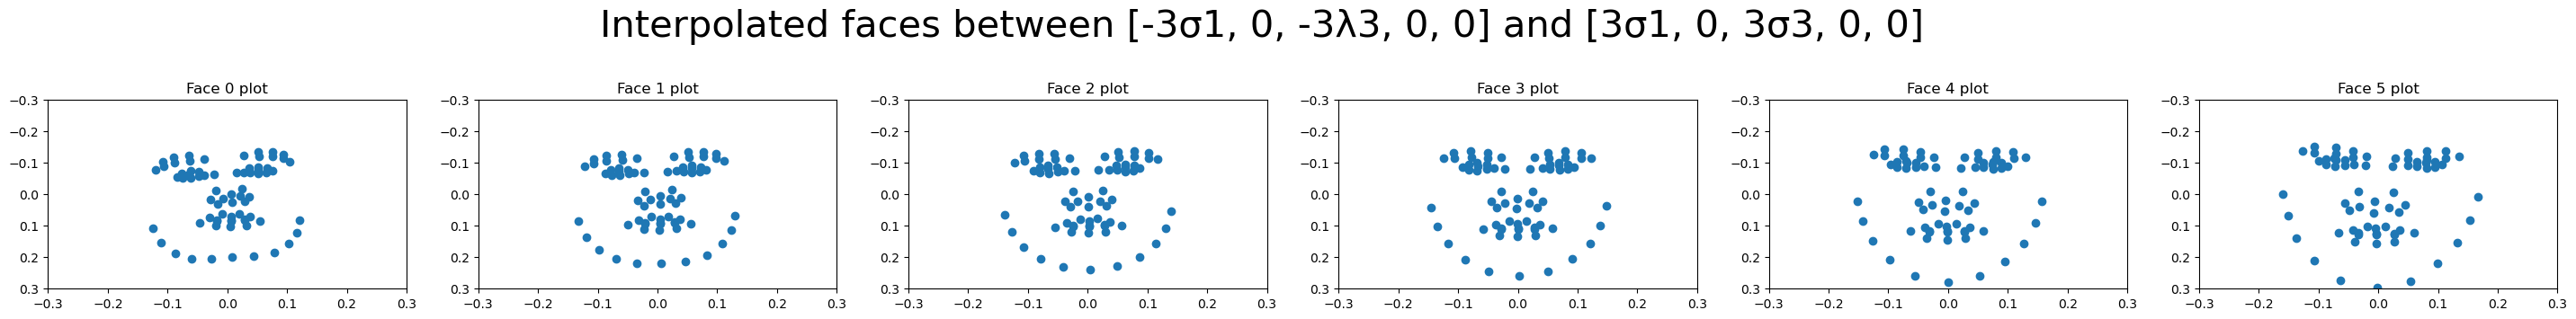

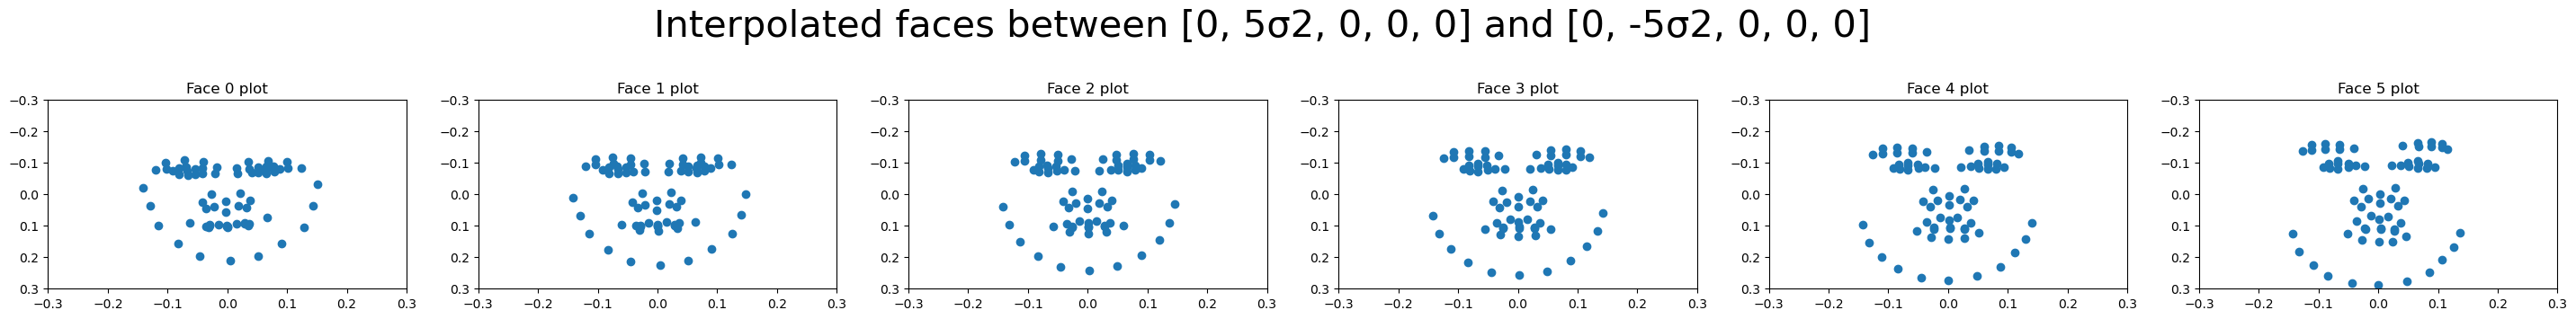

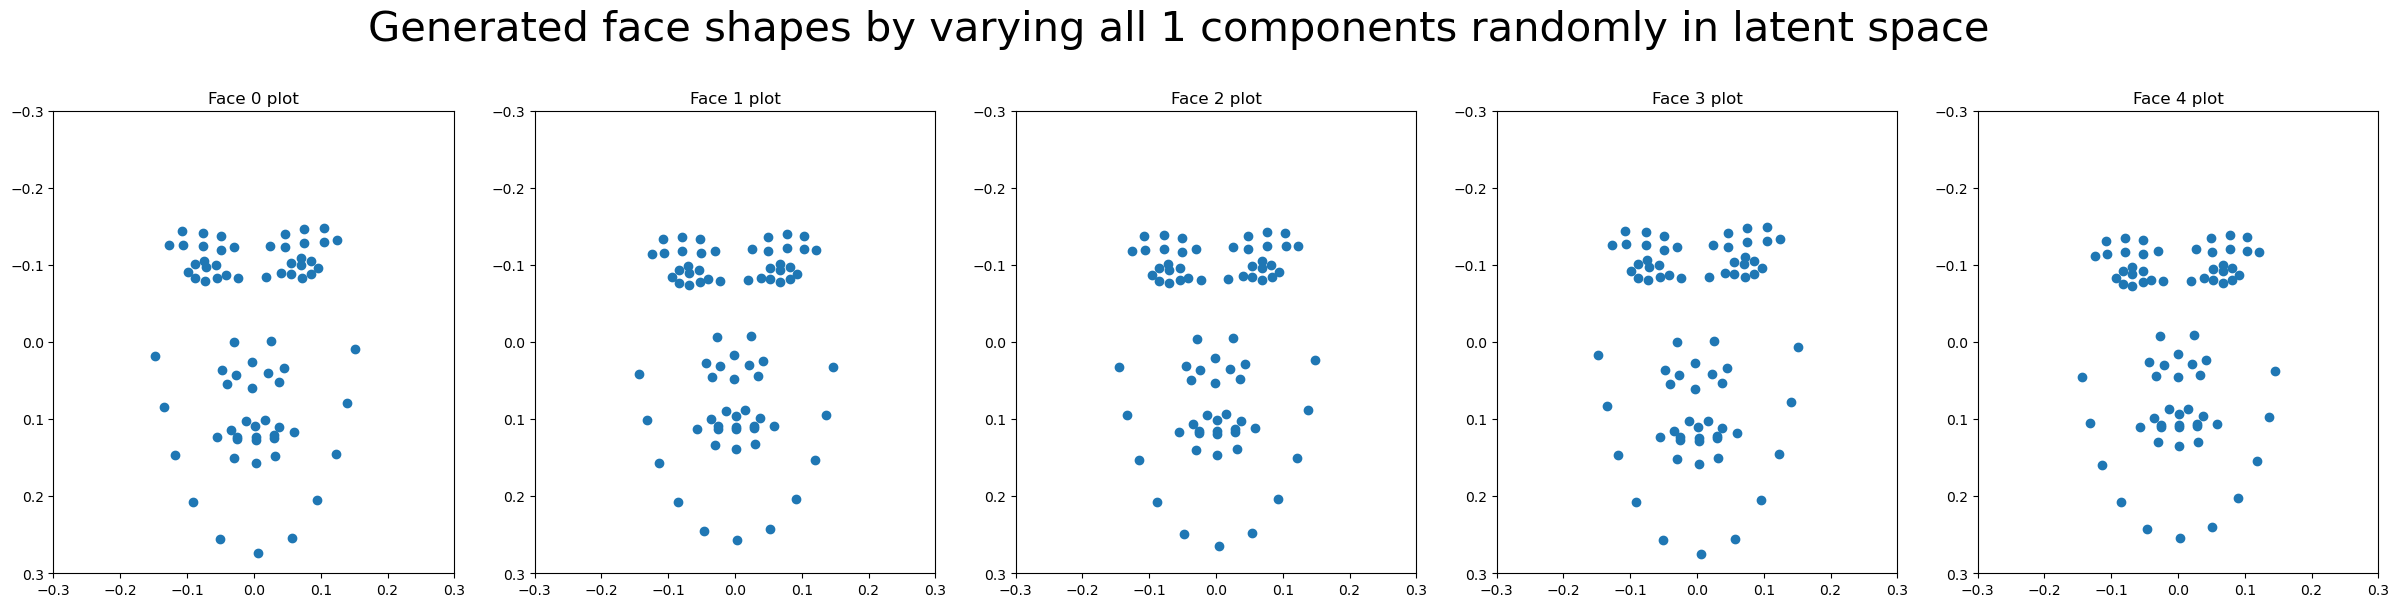

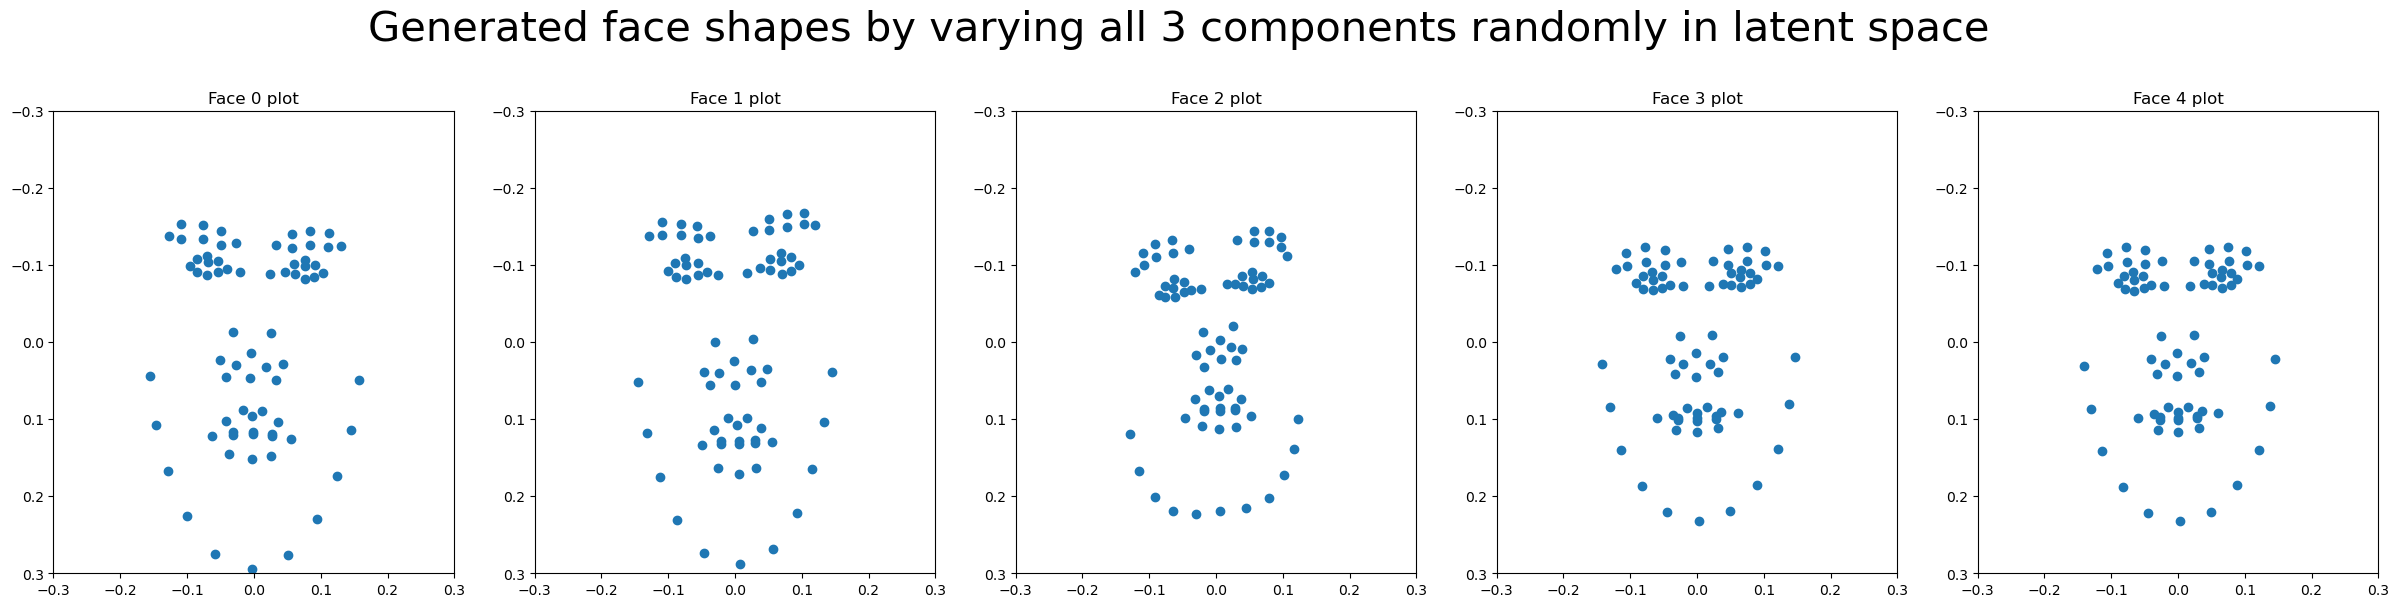

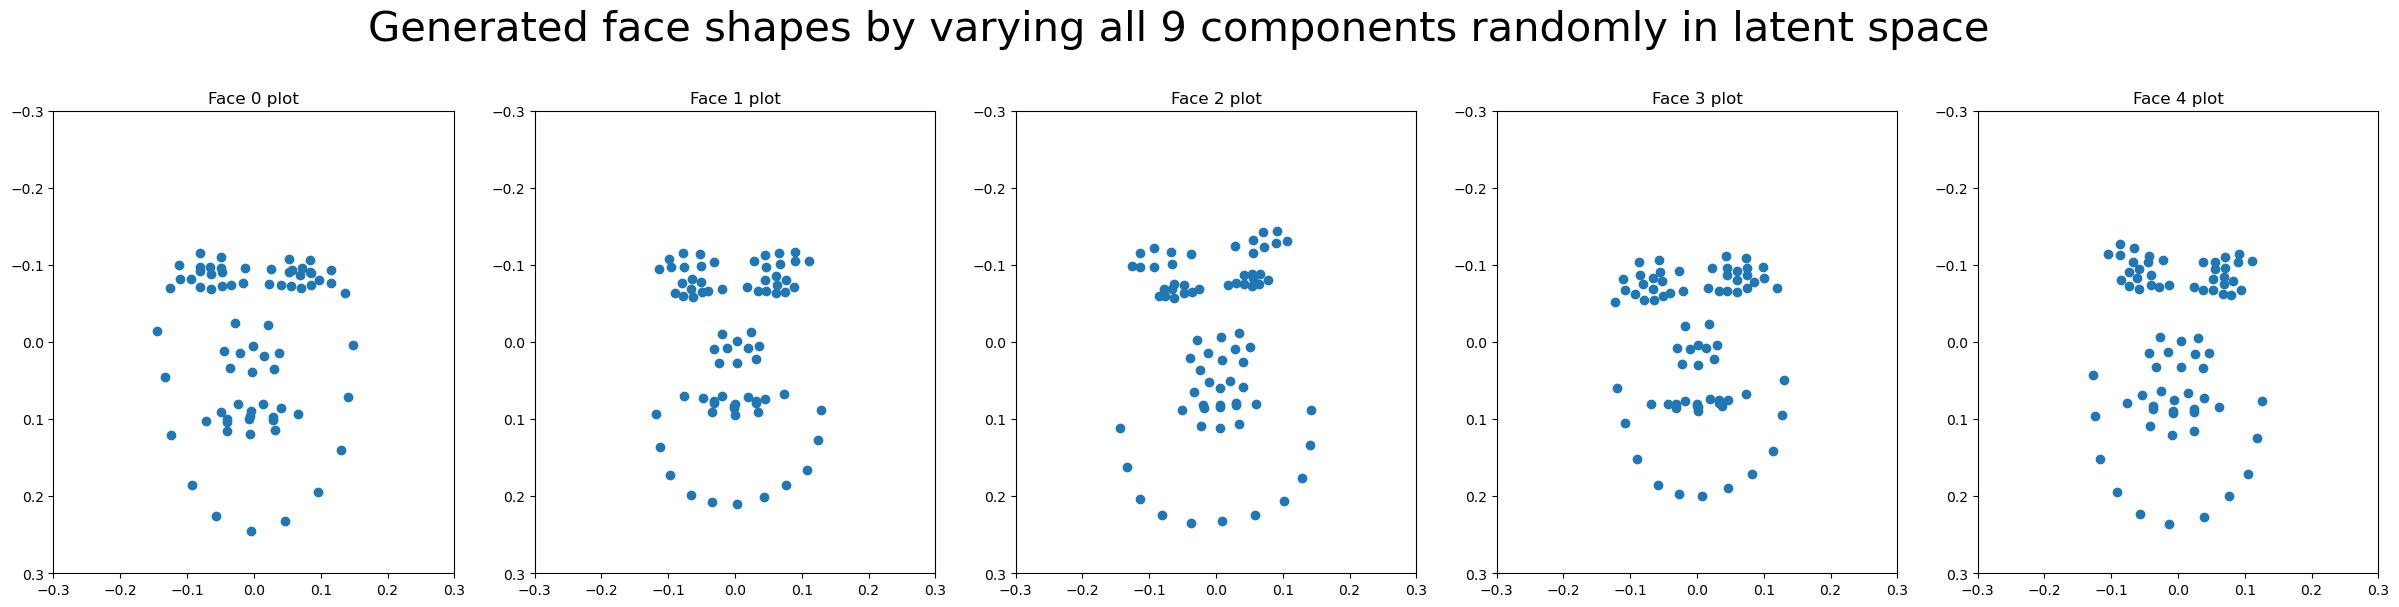

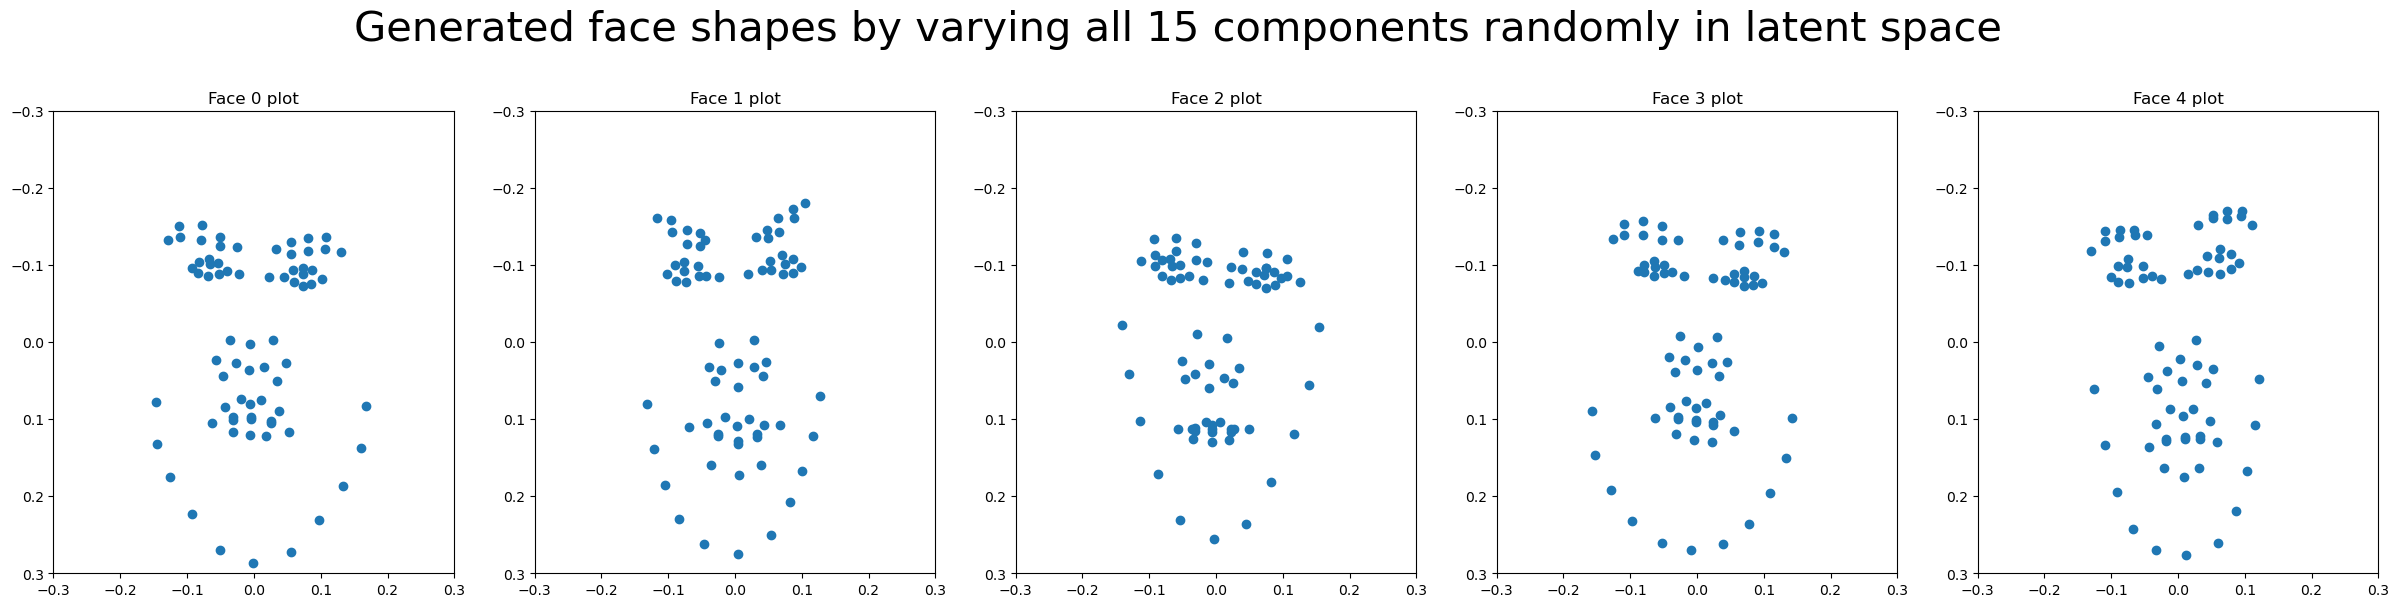

In [10]:
# We chose to use square root to enhance the values because we otherwise had very little variation in the outputs
std_devs = [np.sqrt(val[i]) for i in range(5)]

# Define the points a and b in latent space for each case
# Interpolate between [-3*lambda_1, 0, -3*lambda_3, 0, 0] and [3*lambda_1, 0, 3*lambda_3, 0, 0]
a1 = np.array([-3 * std_devs[0], 0, -3 * std_devs[2], 0, 0])
b1 = np.array([3 * std_devs[0], 0, 3 * std_devs[2], 0, 0])


# Interpolate between [0, 5*lambda_2, 0, 0, 0] and [0, -5*lambda_2, 0, 0, 0]
a2 = np.array([0, 5 * std_devs[1], 0, 0, 0])
b2 = np.array([0, -5 * std_devs[1], 0, 0, 0])


# Interpolation and plotting function remains the same
def interpolate_and_plot(a, b, title):
    # Generate 6 interpolated points
    interpolated_points = np.linspace(a, b, num=6)
    
    #print(interpolated_points)
    
    # Generate faces from each interpolated point
    generated_faces = [transform_from_latent_space(point.reshape(1, -1), Phi_k, mu)[0] for point in interpolated_points]
    
    # Plot the generated faces
    plot_many_faces(generated_faces, title)

# Plot interpolated faces for each pair
interpolate_and_plot(a1, b1, "Interpolated faces between [-3σ1, 0, -3λ3, 0, 0] and [3σ1, 0, 3σ3, 0, 0]")
interpolate_and_plot(a2, b2, "Interpolated faces between [0, 5σ2, 0, 0, 0] and [0, -5σ2, 0, 0, 0]")

# Function to generate faces by varying all components randomly within a range for a specified k
def generate_faces_randomly_for_k(k, eigenvalues, Phi, mu, num_variations=5):
    # Calculate standard deviations for the first k components
    std_values = np.sqrt(eigenvalues[:k])
    gen_faces_all = []

    # Select the first k principal components from Phi
    Phi_k = Phi[:, :k]

    for _ in range(num_variations):
        # Randomly set each component between -3*std and +3*std
        a = np.random.uniform(-3 * std_values, 3 * std_values, size=k)
        face = transform_from_latent_space(a.reshape(1, -1), Phi_k, mu)
        gen_faces_all.append(face[0])

    # Plot faces for each random variation
    plot_many_faces(gen_faces_all, f"Generated face shapes by varying all {k} components randomly in latent space")

# Example usage for k=1, k=3, k=9, and k=15
k_values = [1, 3, 9, 15]
for k in k_values:
    generate_faces_randomly_for_k(k, val, comp, mu)




---
**Task 7 (medium): Reflection💡**
Describe and reflect on the results obtained from this assignment, the exercises and the in-class exercises. Answer the following questions:
1. **Behaviour:** Explain why, a set of points interpolated on a line in latent space corresponds to a sample on a line in data space using $x = \Phi\mathbf{a} + \mu$. 
2. How well can a few principal components reproduce the samples? What happens with the generated data when the number of components $k$ is changed to 1,3,9, or 15?


---

**1. Behavior of Interpolated Points in Latent Space**

Since we use the transformation x=Φa+μ, which is linear in 'a', and we use different values of 'a' with an interpolation, the output when applying the transformation is arguably linear in the data space that we generate, because Φ and μ are fixed.

**2. Effectiveness of Principal Components and Impact of  k Values**
* k=1: Captures only the main variance direction, resulting in basic, average-like faces without detailed features.
* k=3: Adds some detail but still lacks fine features, representing general facial shape.
* k=9: Retains most major features, producing faces that closely resemble the originals with good detail.
* k=15: Provides a highly accurate reconstruction, closely matching original faces with added finer details.

In summary, low k values capture general shape, while higher k values add detailed features.
With a higher k, we are able to change finer details such as angle of eyebrows, rotation of mouth, etc.
But with a low k, we are only able to change the major features that varies the most, such as length of jaw.




## Last section - optional
This final section includes three tasks that offer valuable insights into the application of PCA, however completing this section is optional.

---
**Task 8 (medium): Eigenvalues and eigenvectors of correlation matrix _(optional)_👩‍💻💡**
1. Implement the function `get_principal_components_correlation`
 according to the comments in the cell below.
2. Use the provided code to display the eigenvalues of the correlation matrix.
3. How do the eigenvalues obtained from the covariance matrix compare to those from the correlation matrix in terms of magnitude and the variance each principal component explains? What does this reveal about the effect of feature scaling on PCA results?


---

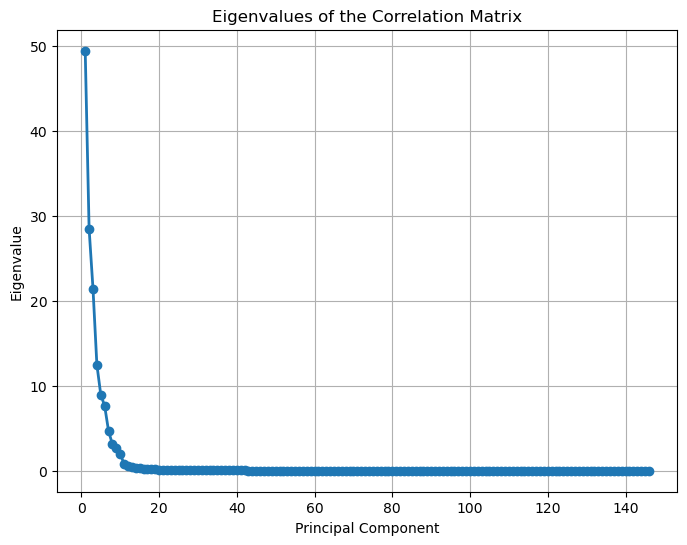

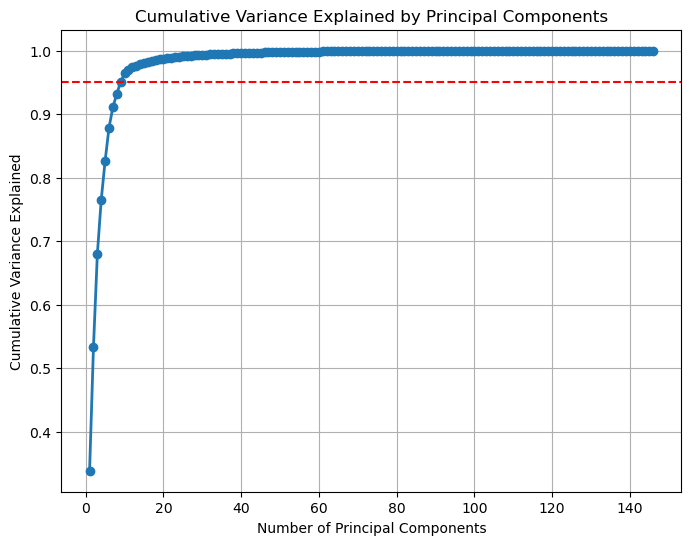

In [11]:
def get_principal_components_correlation(X):
    """Calculates principal components using the correlation matrix for X.

    Args:
        X: The dataset. An NxD array where N are the number of samples and D are
        the number of features.

    Returns:
        Tuple (components, eigenvalues, mu) where components is a DxD matrix of
        principal components, eigenvalues is a D-element vector of
        corresponding eigenvalues, and mu is a D-element array containing the mean
        vector.
    """
    # Standardize the data (subtract mean and divide by standard deviation)
    X_standardized = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    # Compute the correlation matrix
    correlation_matrix = np.corrcoef(X_standardized, rowvar=False)

    # Compute eigenvalues and eigenvectors of the correlation matrix
    eigenvalues, eigenvectors = np.linalg.eigh(correlation_matrix)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    return eigenvectors, eigenvalues, np.mean(X, axis=0)

# Use the function on the shapes data
eigenvectors_corr, eigenvalues_corr, mu_corr = get_principal_components_correlation(shapes)

# Optionally, plot the eigenvalues to see their distribution
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(eigenvalues_corr) + 1), eigenvalues_corr, 'o-', linewidth=2)
plt.title('Eigenvalues of the Correlation Matrix')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

variance_explained = eigenvalues_corr / np.sum(eigenvalues_corr)
cumulative_variance_explained = np.cumsum(variance_explained)

# Plot cumulative variance explained
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_explained) + 1),
         cumulative_variance_explained, 'o-', linewidth=2)
plt.title('Cumulative Variance Explained by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.axhline(y=0.95, color='r', linestyle='--')  # Line to indicate 95% variance
plt.grid(True)
plt.show()

## Task 8 reflection

**How do the eigenvalues obtained from the covariance matrix compare to those from the correlation matrix**

It is basically the same. Correlation is just the normalized version, which takes a little extra computational power to calculate. 


---
**Task 9 (medium): Dimensionality reduction of features _(optional)_👩‍💻💡**
1. **Transform data:** Use $\mathbf{\Phi^{\top}}$​ to transform the data $\mathbf{x}$ into its latent-space representation $\mathbf{x'}$ (using $\mathbf{x'}= \mathbf{\Phi^{\top}}(\mathbf{x}-\mathbf{\mu})$).
2. Plot the first two  components in latent space using a scatterplot.    - What does this plot tell you about the distribution of faces?
    - Try plotting different pairs of components. Describe how each combination separates (clusters) the dataset differently.


3. **Interpolate between real faces:** Re-implement [Task 6](#interpolate) but instead of selecting 2 points in latent space, transform two real faces to latent space and interpolate between them.     - Plot the faces of the interpolated points.




---

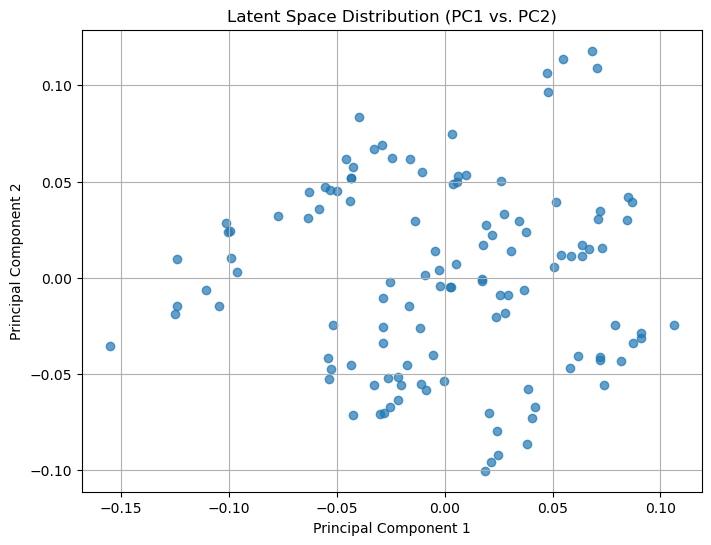

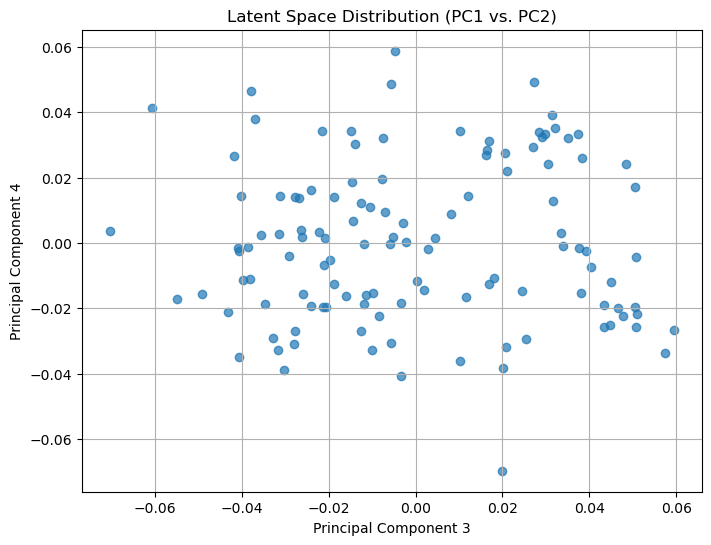

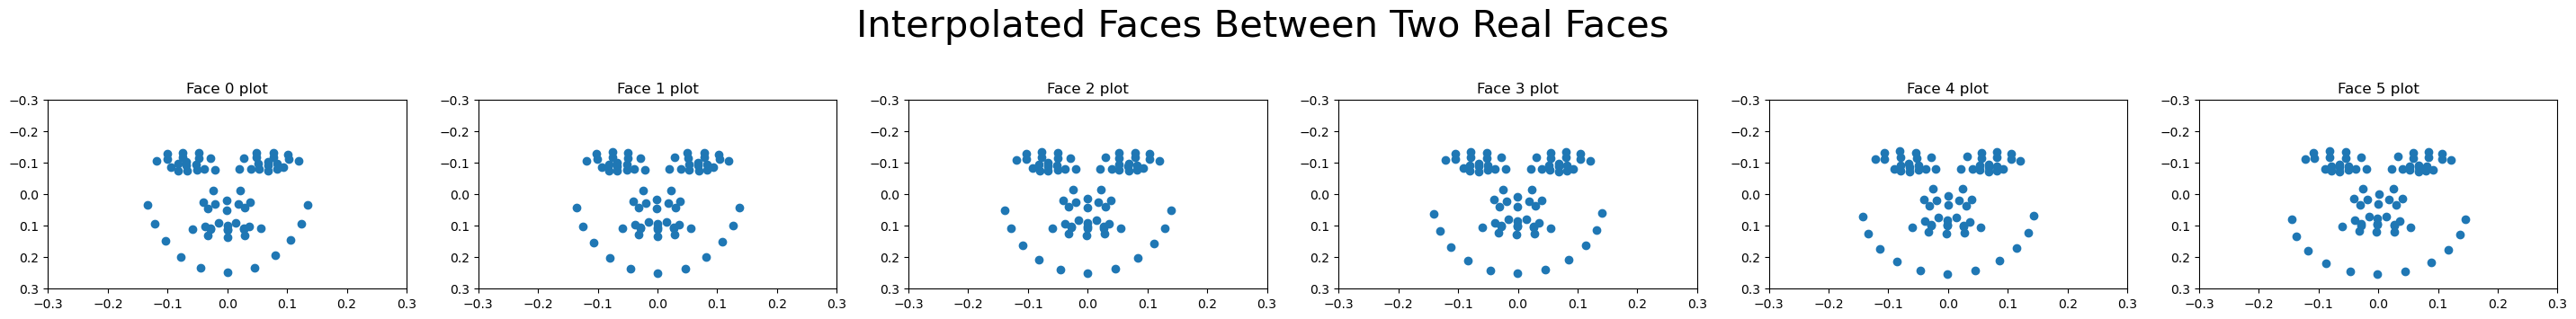

In [12]:
#1. Transform Data to Latent Space
# Use the first few principal components
Phi = comp[:, :5]  # Adjust the number of components as needed

# Transform the data to latent space
shapes_latent = transform_to_latent_space(shapes, Phi, mu)

#2. Plot the First Two Components in Latent Space
# Scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(shapes_latent[:, 0], shapes_latent[:, 1], alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Latent Space Distribution (PC1 vs. PC2)")
plt.grid(True)
plt.show()

# Scatter plot of the 3rd and fourth principal components
plt.figure(figsize=(8, 6))
plt.scatter(shapes_latent[:, 2], shapes_latent[:, 3], alpha=0.7)
plt.xlabel("Principal Component 3")
plt.ylabel("Principal Component 4")
plt.title("Latent Space Distribution (PC1 vs. PC2)")
plt.grid(True)
plt.show()

#3. Interpolate Between Real Faces in Latent Space
# Select two real faces from the dataset
face1 = shapes[0]  # First face
face2 = shapes[-1]  # Last face

# Transform the selected faces to latent space
face1_latent = transform_to_latent_space(face1.reshape(1, -1), Phi, mu)
face2_latent = transform_to_latent_space(face2.reshape(1, -1), Phi, mu)

# Interpolate between the two faces in latent space
interpolated_points = np.linspace(face1_latent, face2_latent, num=6)

# Generate faces from interpolated latent space points and plot
generated_faces = [transform_from_latent_space(point.reshape(1, -1), Phi, mu)[0] for point in interpolated_points]
plot_many_faces(generated_faces, "Interpolated Faces Between Two Real Faces")



## Task 9 reflection

**Describe the different scatter plots of component combinations**

The faces seem pretty evenly spread out when using the first two components. There are a few gaps with no faces.
The third and fourth component scatter plot shows less variation of cause (because the components are ordered by variation) and here the faces are also evenly spread with fewer gaps.



---
**Task 10 (medium): Out of distribution generation _(optional)_👩‍💻💡**
1. **Extreme values:** What happens if you select values outside the suggested range. Explain why this happens.


---

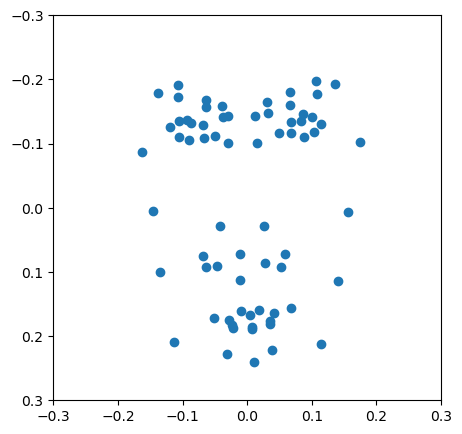

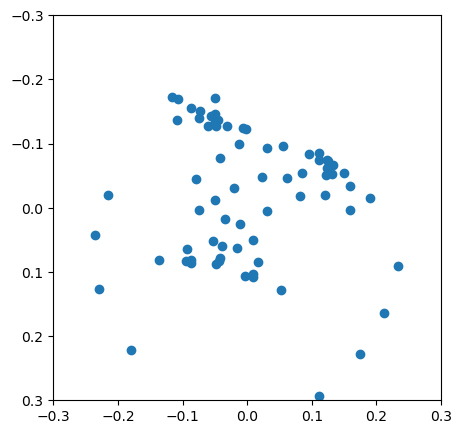

In [13]:
extreme = np.array([np.sqrt(val[0])*10,0,0,0,0])
# Generate the corresponding face in data space
face_extreme = transform_from_latent_space(extreme.reshape(1, -1), Phi_k, mu)
plot_face(face_extreme[0])

extreme2 = np.array([0,0,np.sqrt(val[2])*20,0,0])
# Generate the corresponding face in data space
face_extreme2 = transform_from_latent_space(extreme2.reshape(1, -1), Phi_k, mu)
plot_face(face_extreme2[0])

## Task 10 reflection

**Effect of Selecting Values Outside the Suggested Range:**

When selecting values for the latent space vector 'a' outside the recommended range [−3σ,3σ], generated faces can look unrealistic or distorted. This occurs because PCA assumes a normal distribution within each principal component's direction. Values beyond ±3σ fall outside the 99.7% data range, pushing the shape outside the learned distribution.